## Setup, Loading Data and CDFs

In [4]:
DATA_NAME = 'ravdess-1e5geore' #dataset-compression
TRANSFORM = 'fft-strong_intensity' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [5]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
strong_intensity_fft_1e5geore_ravdess.ipynb


In [6]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geore\\fft\\strong_intensity'

In [7]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [8]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [9]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [10]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


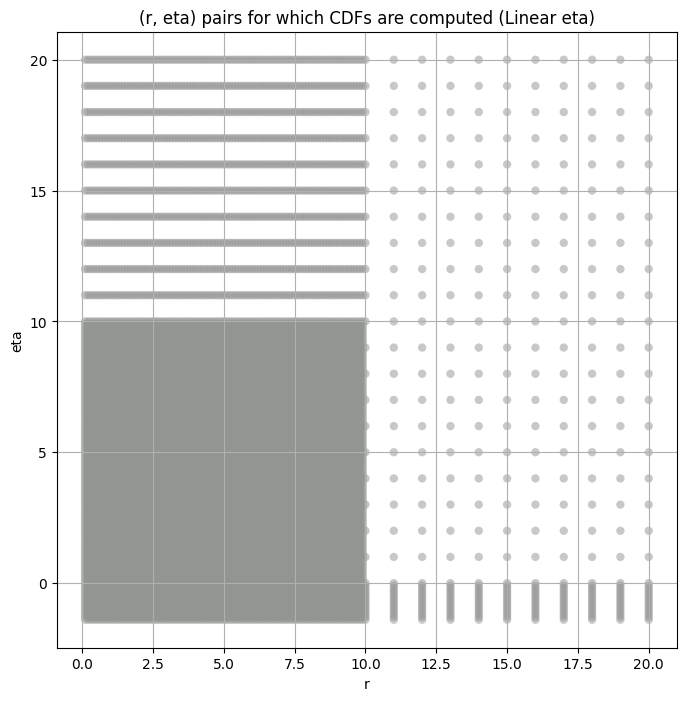

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [11]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [12]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [13]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 30


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     3.398420e+14  2.885051e+14  3.995387e+14   9.000777    4.606562   
5     7.662681e+14  6.650100e+14  8.746015e+14  20.540274   17.320919   
8     1.821735e+14  1.584012e+14  2.083324e+14  26.358736   19.246767   
11    1.046289e+13  9.638602e+12  1.150689e+13   9.936844    3.401560   
14    1.560234e+14  1.304501e+14  1.856061e+14  45.615188   30.371928   
17    3.990450e+14  3.719449e+14  4.288389e+14   5.597486    3.714605   
20    1.262817e+14  1.167970e+14  1.372043e+14   7.630152    4.533955   
23    1.395216e+13  1.305865e+13  1.496807e+13   4.887635    2.577196   
26    3.501565e+12  3.257119e+12  3.775443e+12   6.210594    3.889244   
30    4.320761e+10  3.905582e+10  4.823722e+10  14.671866    8.267646   

      kurt_upper  total_samples  
band                             
2      13.104665         1344.0  
5      23.905913         4032.0  
8      34.415209        11424.0  
11     23.645956        31584.0  
14     68.155309        87360.0  
17      9.365635       100000.0  
20     17.732023       100000.0  
23     12.244421       100000.0  
26     12.906360       100000.0  
30     37.024622       100000.0

## Initial Grid Search and Hypothesis Test Plots

In [14]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [15]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     3.398420e+14   3.398420e+14    2.243275e+14    1.889159e+14   
5     7.662681e+14   7.662681e+14    5.400746e+14    4.243783e+14   
8     1.821735e+14   1.821735e+14    1.490701e+14    1.344479e+14   
11    1.046289e+13   1.046289e+13    9.811017e+12    9.526371e+12   
14    1.560234e+14   1.560234e+14    1.412634e+14    1.325117e+14   
17    3.990450e+14   3.990450e+14    3.872491e+14    3.802565e+14   
20    1.262817e+14   1.262817e+14    1.217893e+14    1.192861e+14   
23    1.395216e+13   1.395216e+13    1.352966e+13    1.330812e+13   
26    3.501565e+12   3.501565e+12    3.391247e+12    3.326647e+12   
30    4.320761e+10   4.320761e+10    4.100772e+10    3.983419e+10   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       1.658024e+14     1.478496e+14     1.204579e+14     1.003634e+14   
5       3.481080e+14     2.964386e+14     2.294462e+14     1.855884e+14   
8       1.227844e+14     1.125570e+14     9.583955e+13     8.305758e+13   
11      9.315512e+12     9.144432e+12     8.857156e+12     8.632422e+12   
14      1.259072e+14     1.203034e+14     1.110743e+14     1.036299e+14   
17      3.747075e+14     3.699115e+14     3.615884e+14     3.544050e+14   
20      1.172947e+14     1.155630e+14     1.125828e+14     1.100363e+14   
23      1.313004e+13     1.297633e+13     1.271271e+13     1.248624e+13   
26      3.274187e+12     3.228375e+12     3.149438e+12     3.081890e+12   
30      3.890140e+10     3.810456e+10     3.675625e+10     3.562144e+10   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        8.551128e+13     7.366895e+13     6.370058e+13     4.205595e+13  
5        1.543986e+14     1.334183e+14     1.189349e+14     9.021860e+13  
8        7.324897e+13     6.565223e+13     5.952104e+13     4.752592e+13  
11       8.446990e+12     8.285395e+12     8.140313e+12     7.769663e+12  
14       9.736783e+13     9.187007e+13     8.699066e+13     7.513314e+13  
17       3.479523e+14     3.420370e+14     3.365566e+14     3.220924e+14  
20       1.077693e+14     1.057168e+14     1.038360e+14     9.892730e+13  
23       1.228540e+13     1.210331e+13     1.193523e+13     1.149494e+13  
26       3.022142e+12     2.968162e+12     2.918680e+12     2.789617e+12  
30       3.462669e+10     3.373899e+10     3.293408e+10     3.087117e+10

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.013059603704591763 339842009132118.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.016315417984730907 224327531435091.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.025909640537308043 188915883632237.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.033732695146174274 165802385519829.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.041089067366147036 147849623185807.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.06371621099103597 120457926798213.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.08438018504078423 100363424984187.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.10207031293899853 85511279788465.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.11793635478616749 73668945721470.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.13348424201256548 63700581627396.82


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.17769218919807517 42055947983885.33
Number of samples: 2688, Without approximation : 1344.0


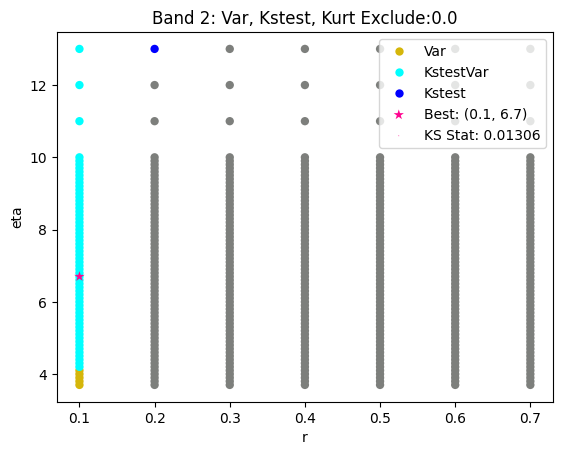

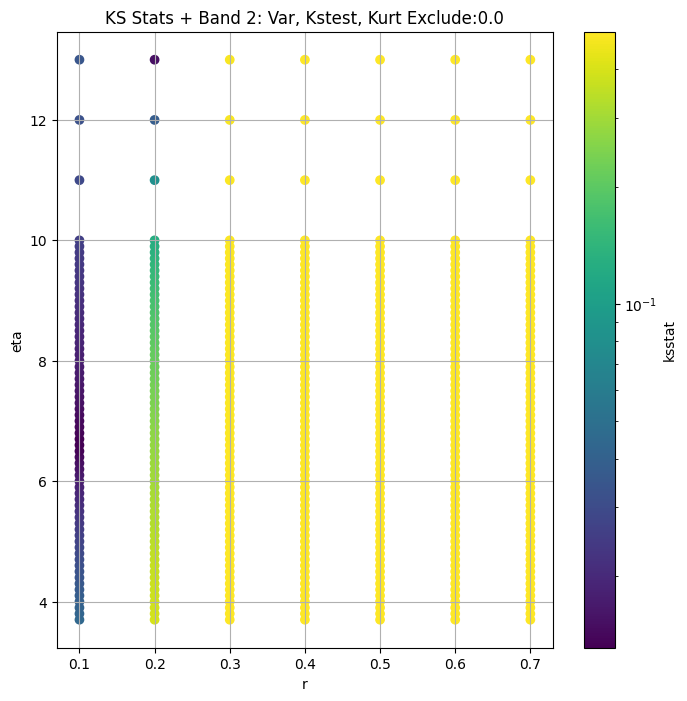

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.030107314380265038 766268111181549.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.02236040277922391 540074573043837.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.018119744028253948 424378258545682.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.015651836610528824 348108020073185.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.018459946564430285 296438649193392.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.022916803414373656 229446201172306.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.028201313757902108 185588358559700.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.03429924559794719 154398642206944.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.04131794367614817 133418265400424.95


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.04691719244460471 118934859551946.27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.0625297008927076 90218602104656.16
Number of samples: 8064, Without approximation : 4032.0


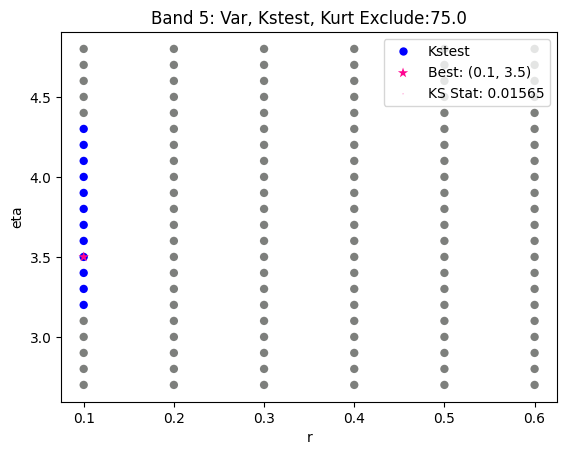

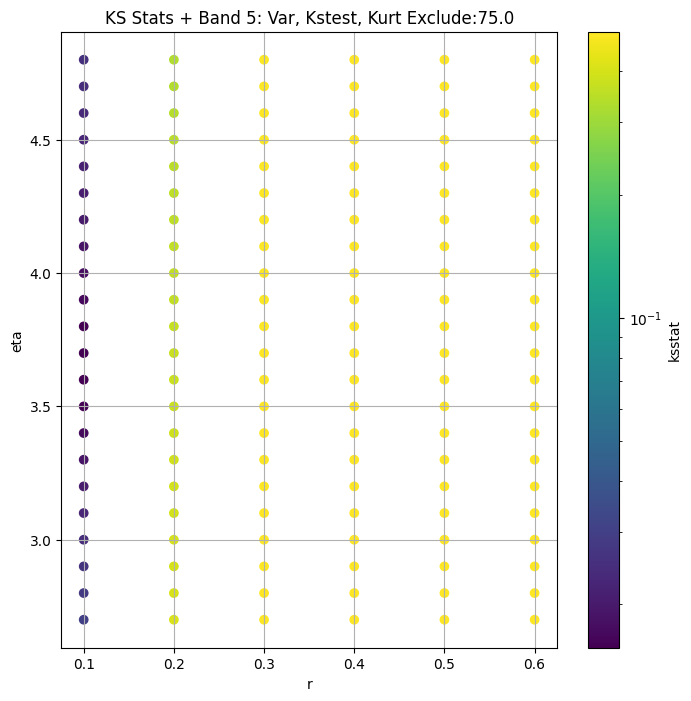

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.019951055189934286 182173455294249.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.019951055189934286 149070134901007.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.019951055189934286 134447908634239.95


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.019951055189934286 122784371912520.39


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.019951055189934286 112556984601317.33


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.01573255770004353 95839548957916.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.01287581582825248 83057583704818.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.014548192391106829 73248966802490.27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.01623657454728568 65652227816507.33


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.017891483665864683 59521043421114.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.023305307684517555 47525915523054.18
Number of samples: 22848, Without approximation : 11424.0


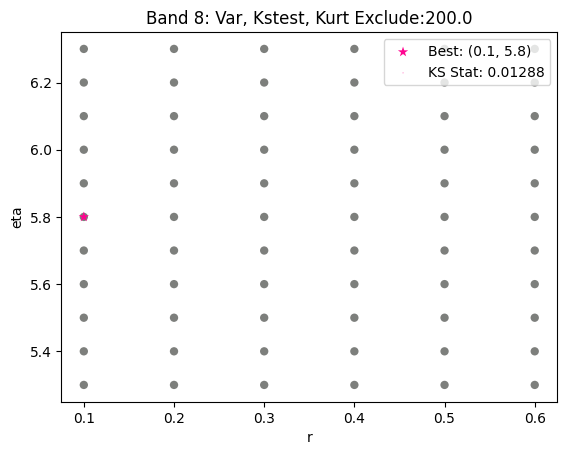

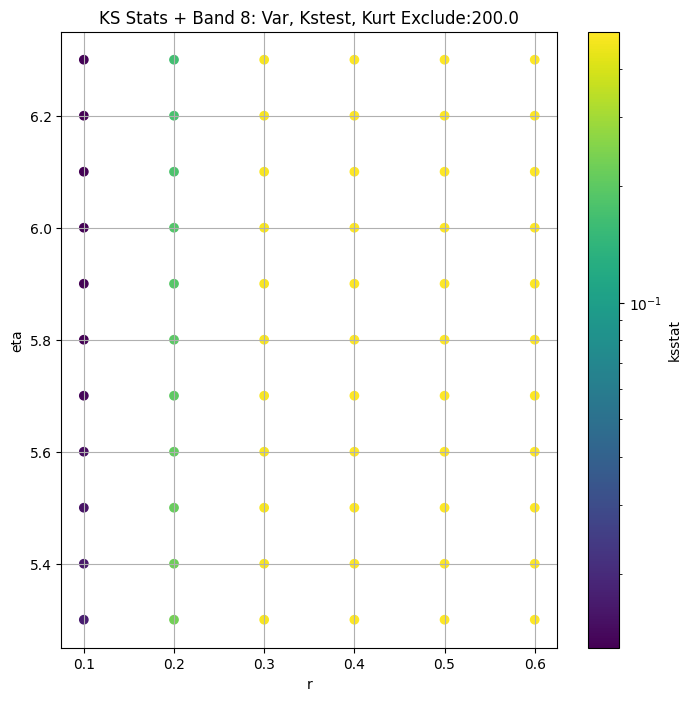

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.007198792760903704 10462887871677.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.005069498150016692 9811016640565.043


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.0036136689848414935 9526371102407.336


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.002436352136907849 9315511702771.133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.0026169673098030786 9144432111146.162


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.0032008184138413442 8857155931129.205


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.004078442010514327 8632422303874.331


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.00504200030163382 8446989570193.318


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.006035683067591703 8285395133582.7705


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.0070352085600206005 8140312501709.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.011482686045979684 7769662639774.313
Number of samples: 63168, Without approximation : 31584.0


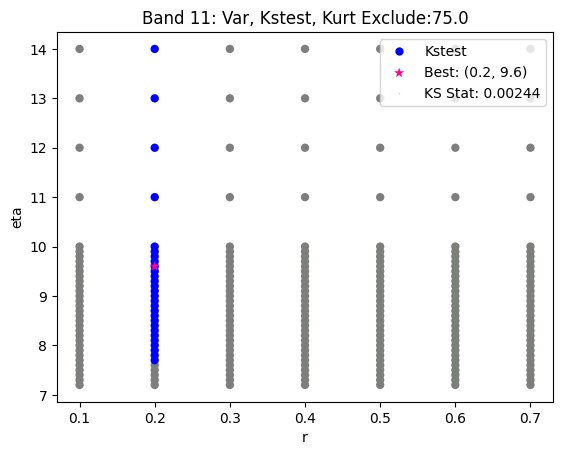

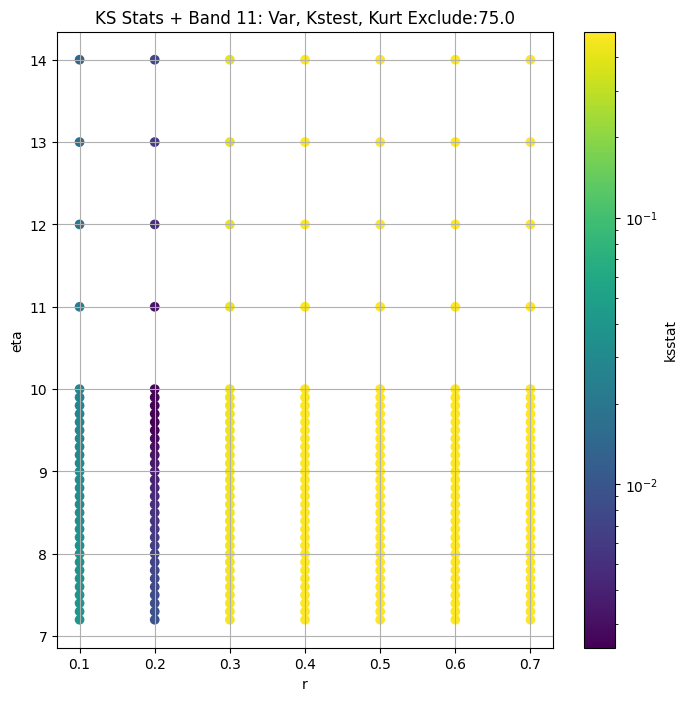

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.03643724550501293 156023378056305.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.03366940122122253 141263437657581.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.03111722520762722 132511742184473.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.03313394873994263 125907163281763.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.03410298603320039 120303382007417.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.029438803547183423 111074275495974.73


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.03041558102316072 103629875923845.67


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.030370937143042842 97367828132515.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.02690230921970005 91870073946700.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.028050952758371328 86990662243042.45


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.025489876664247846 75133140574770.23
Number of samples: 100000, Without approximation : 87360.0


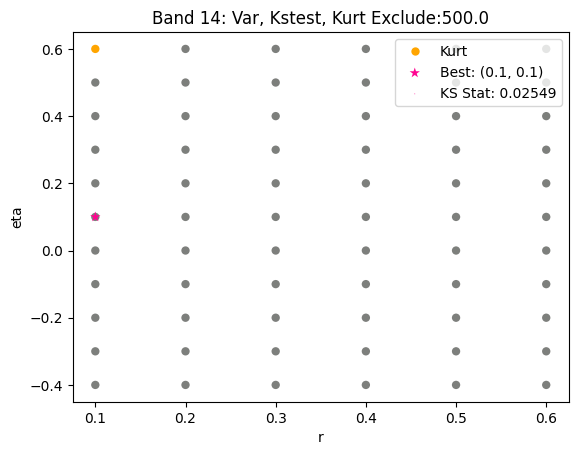

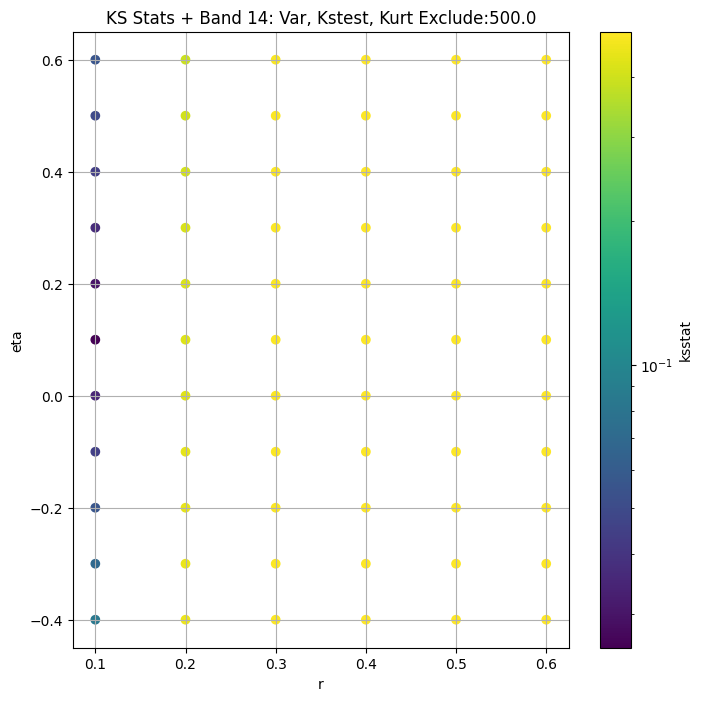

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.012848868407637437 399044973851055.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.01347162061910874 387249126439068.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.013817508180979265 380256478520055.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.014154063018006424 374707484377955.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.014581633934394128 369911545957366.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.014987874635350451 361588386957917.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.015341826338793552 354404984508660.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.01582429877437108 347952335046069.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.016288569140060466 342036952494604.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.016725237641493917 336556584897335.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.017930221978652572 322092398825481.5
Number of samples: 100000, Without approximation : 100000.0


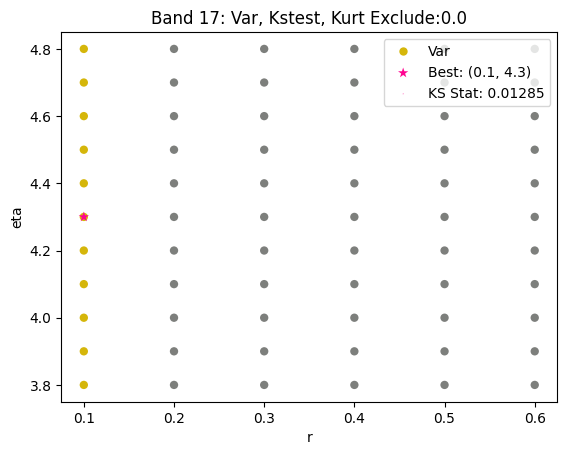

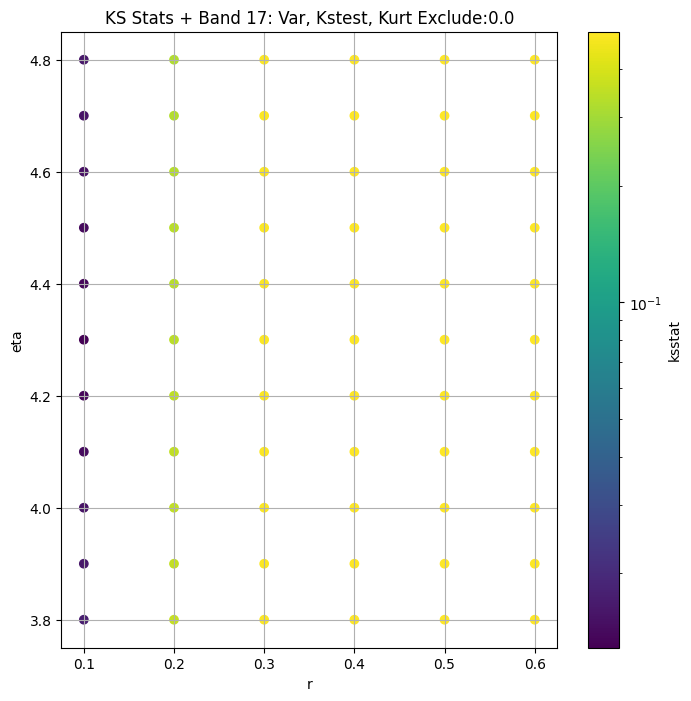

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.0017970888719641698 126281703477636.95


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.0014715827146809524 121789298558765.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.0021901325528094 119286139206284.39


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.0027865734676154955 117294652872119.48


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.003318753881521596 115563032815970.11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.004287574512948013 112582786786423.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.005163103496356031 110036324720395.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.00601583603672113 107769281232133.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.006803434666998162 105716765354698.67


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.007559698954400791 103835993279623.55


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.009671008187102113 98927297669674.64
Number of samples: 100000, Without approximation : 100000.0


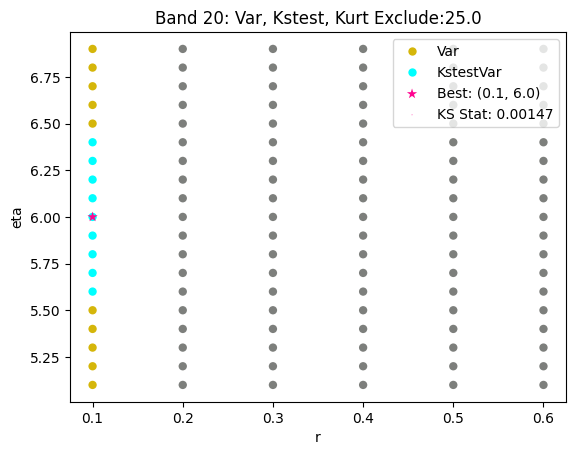

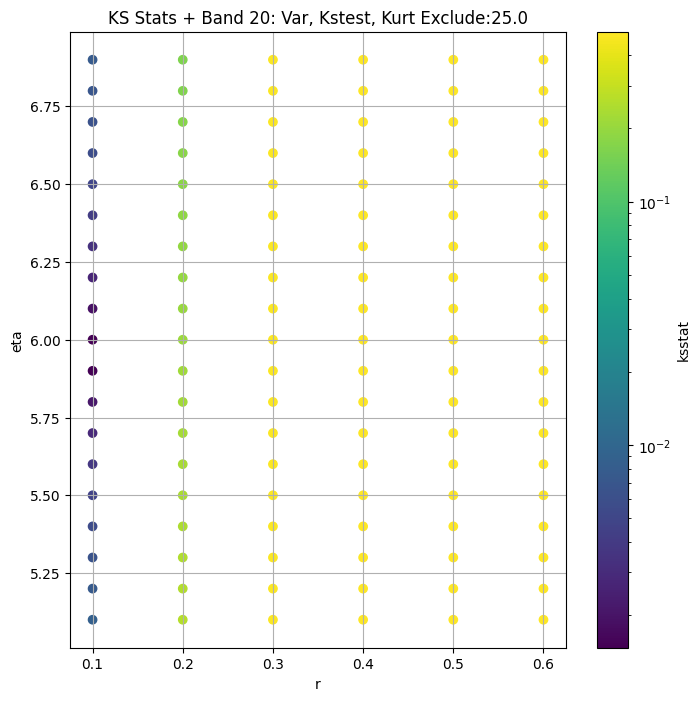

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.001938020089361503 13952162996874.242


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0008972847652777283 13529662528674.15


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.001011201172675072 13308123493736.15


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.001334202178082649 13130038978604.463


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0019201588802221121 12976329971718.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.002701947690741228 12712707524930.797


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.0035875886838396126 12486240837810.74


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.004441793179262625 12285397642533.826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.0052534520193754305 12103310300816.697


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.006025913074018743 11935233773078.996


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.008202346907755842 11494942958991.742
Number of samples: 100000, Without approximation : 100000.0


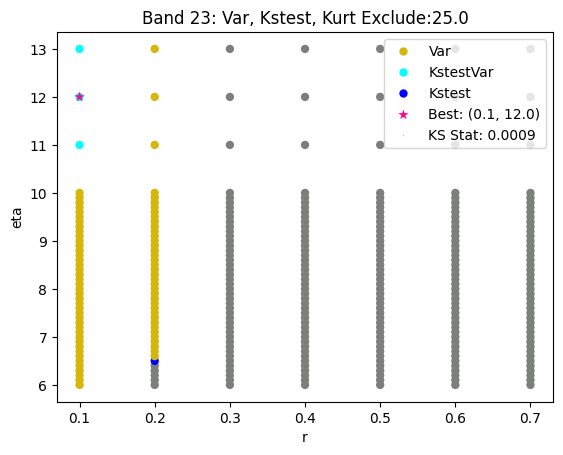

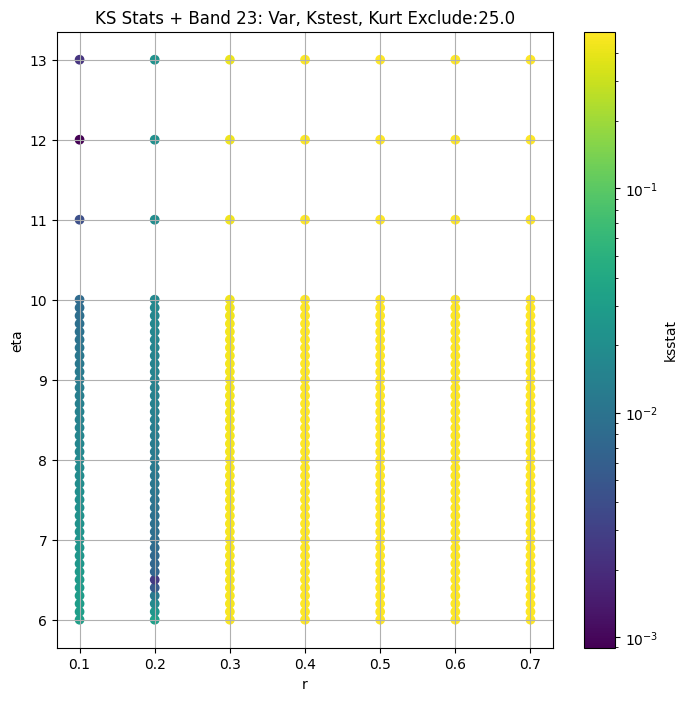

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.0019694589785834715 3501565299877.888


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.00118892360734002 3391247479364.459


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.0014673400424173866 3326646762783.1313


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0019227707113286946 3274187324883.244


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.0024102131995080885 3228375255449.295


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.003386642313274131 3149437844241.9688


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.00427069834658941 3081890402447.807


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.004876334073600816 3022141834018.015


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.00560641507959618 2968161916769.3604


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.006373025333364486 2918680434062.5156


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.008542691667489749 2789617396880.0137
Number of samples: 100000, Without approximation : 100000.0


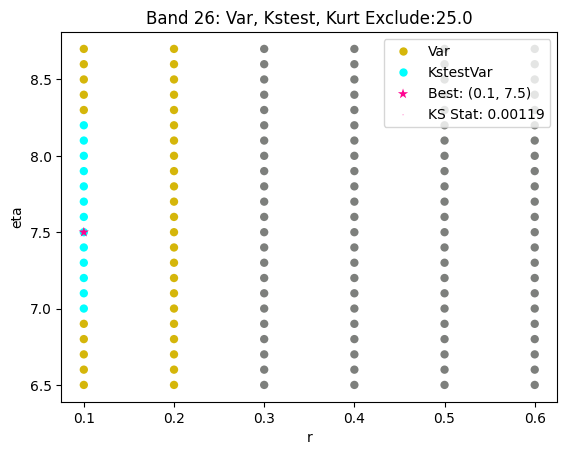

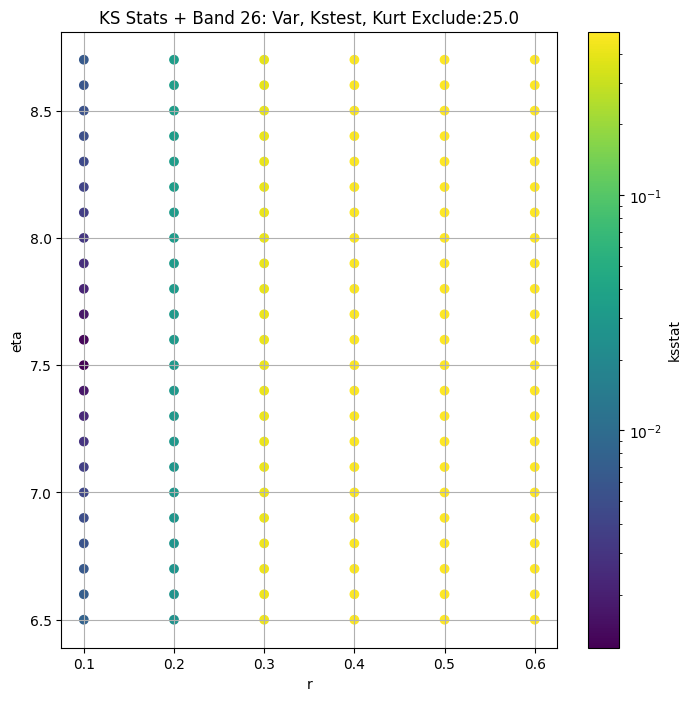

####
Band  30


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 0 0.005744612209594213 43207613574.09835


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 25 0.0047000377793141035 41007723821.86944


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 50 0.004513851606071317 39834187217.398735


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 75 0.0038726298068779696 38901397056.90847


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 100 0.0038485589439426968 38104555225.939255


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 150 0.004812216716069136 36756253399.22073


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 200 0.0051106687404648375 35621440958.11011


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 250 0.0059587669270885525 34626686603.95224


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 300 0.006764586384477019 33738990160.234566


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 350 0.0075093724926441445 32934080735.37214


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 500 0.009628944626533971 30871165214.90839
Number of samples: 100000, Without approximation : 100000.0


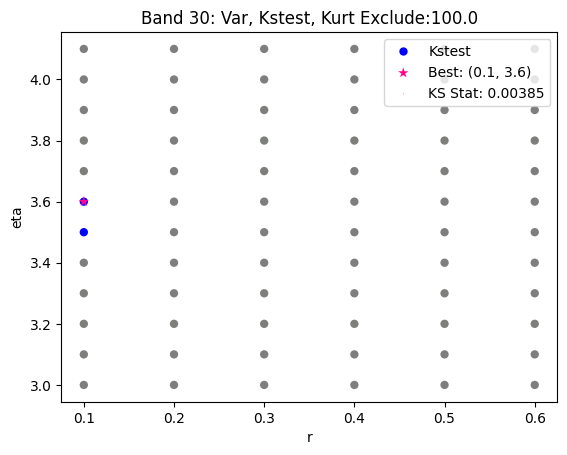

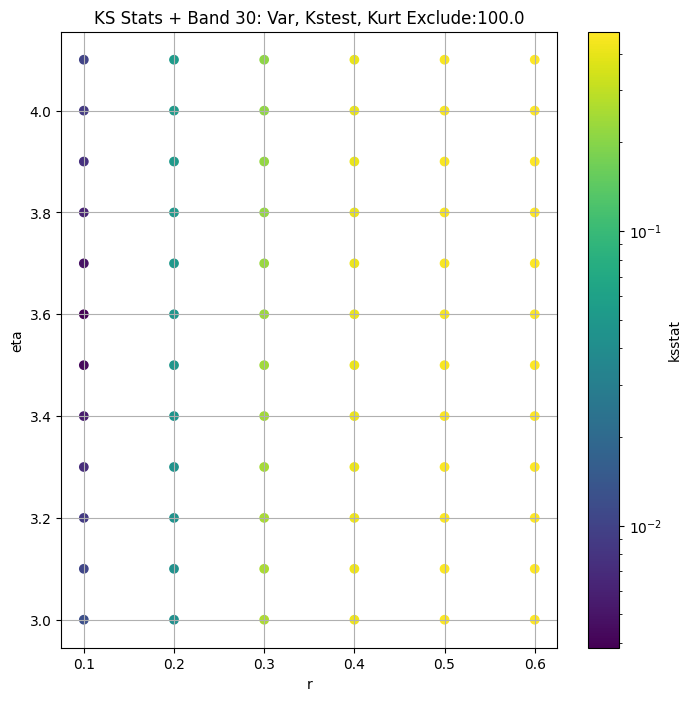

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     3.398420e+14  2.885051e+14  3.995387e+14   9.000777    4.606562   
5     7.662681e+14  6.650100e+14  8.746015e+14  20.540274   17.320919   
8     1.821735e+14  1.584012e+14  2.083324e+14  26.358736   19.246767   
11    1.046289e+13  9.638602e+12  1.150689e+13   9.936844    3.401560   
14    1.560234e+14  1.304501e+14  1.856061e+14  45.615188   30.371928   
17    3.990450e+14  3.719449e+14  4.288389e+14   5.597486    3.714605   
20    1.262817e+14  1.167970e+14  1.372043e+14   7.630152    4.533955   
23    1.395216e+13  1.305865e+13  1.496807e+13   4.887635    2.577196   
26    3.501565e+12  3.257119e+12  3.775443e+12   6.210594    3.889244   
30    4.320761e+10  3.905582e+10  4.823722e+10  14.671866    8.267646   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      13.104665         1344.0             0.013060        0.1          6.7   
5      23.905913         4032.0             0.015652        0.1          3.5   
8      34.415209        11424.0             0.012876        0.1          5.8   
11     23.645956        31584.0             0.002436        0.2          9.6   
14     68.155309        87360.0             0.025490        0.1          0.1   
17      9.365635       100000.0             0.012849        0.1          4.3   
20     17.732023       100000.0             0.001472        0.1          6.0   
23     12.244421       100000.0             0.000897        0.1         12.0   
26     12.906360       100000.0             0.001189        0.1          7.5   
30     37.024622       100000.0             0.003849        0.1          3.6   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.457178e-05                     0.0        3.398420e+14   
5      1.526846e-03                    75.0        3.481080e+14   
8      1.069913e-05                   200.0        8.305758e+13   
11     1.484310e+04                    75.0        9.315512e+12   
14     6.334108e+00                   500.0        7.513314e+13   
17     4.434212e-04                     0.0        3.990450e+14   
20     1.215558e-05                    25.0        1.217893e+14   
23     4.858093e-09                    25.0        1.352966e+13   
26     5.998589e-08                    25.0        3.391247e+12   
30     1.392762e-07                   100.0        3.810456e+10   

      kstest_stat_cutoff_0.05  
band                           
2                    0.036919  
5                    0.021346  
8                    0.012692  
11                   0.007637  
14                   0.004593  
17                   0.004293  
20                   0.004293  
23                   0.004293  
26                   0.004293  
30                   0.004293

In [16]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [17]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.06227762431751094, var: 147849623185807.06


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.05037984193368608, var: 165802385519829.28


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.03700568977993954, var: 188915883632237.6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.019781006436327186, var: 224327531435091.22


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.0100440142178288, var: 339842009132118.1
Number of samples: 2688, Without approximation : 1344.0


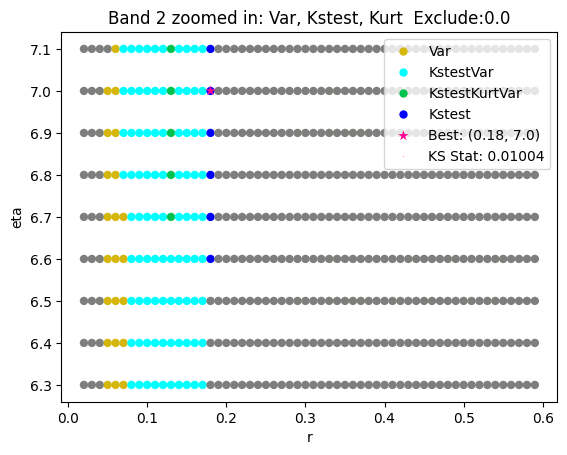

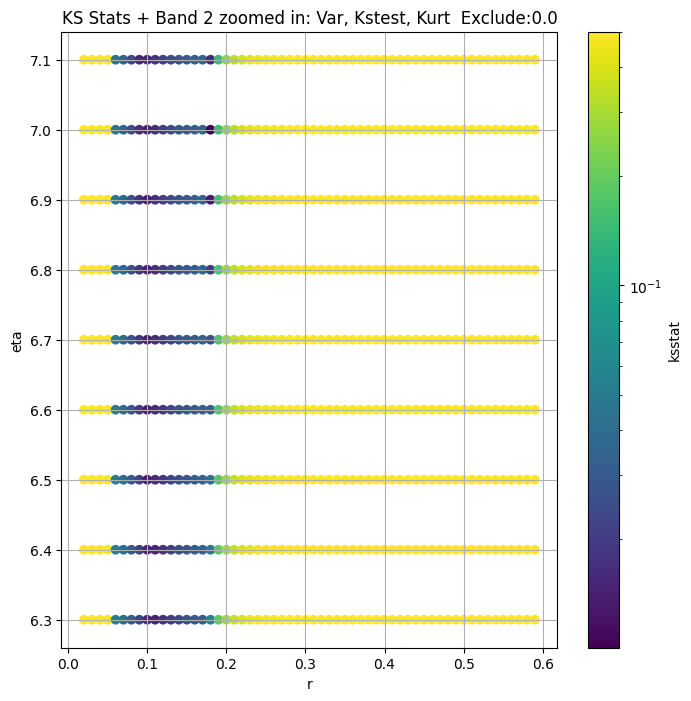

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 100 = 175, ksstat: 0.0251814018402019, var: 205642237914434.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 75 = 150, ksstat: 0.02292839742866158, var: 229446201172306.75


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 50 = 125, ksstat: 0.020874056998145568, var: 258531343226123.16


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 25 = 100, ksstat: 0.01841278109301573, var: 296438649193392.6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 0 = 75, ksstat: 0.015651836610528824, var: 348108020073185.3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + -25 = 50, ksstat: 0.017497106285916136, var: 424378258545682.25


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + -50 = 25, ksstat: 0.019950002538455913, var: 540074573043837.25


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + -75 = 0, ksstat: 0.019950002538455913, var: 766268111181549.1
Number of samples: 8064, Without approximation : 4032.0


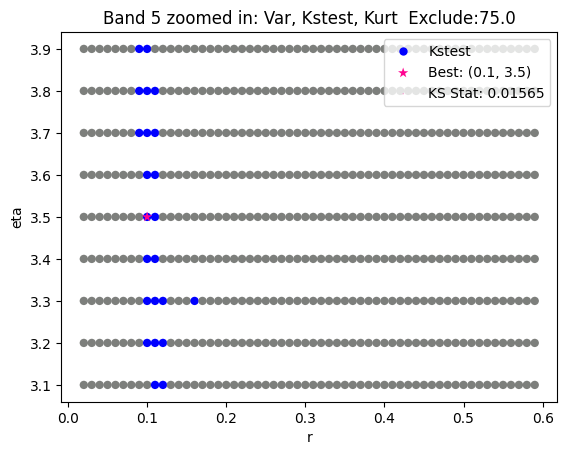

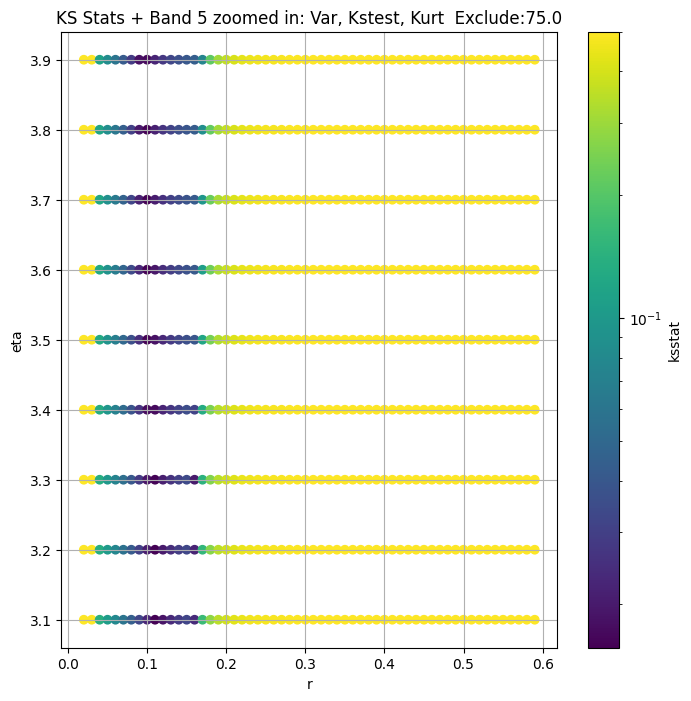

Band 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 100 = 300, ksstat: 0.016269295769658562, var: 65652227816507.33


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 75 = 275, ksstat: 0.01539015205740446, var: 69290390454942.96


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 50 = 250, ksstat: 0.014549531865167498, var: 73248966802490.27


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 25 = 225, ksstat: 0.013754131765272964, var: 77827092632759.52


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 0 = 200, ksstat: 0.01287581582825248, var: 83057583704818.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -25 = 175, ksstat: 0.013522696350032226, var: 89029909079471.3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -50 = 150, ksstat: 0.015549577570294959, var: 95839548957916.94


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -75 = 125, ksstat: 0.017913161658218324, var: 103690262954145.89


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -100 = 100, ksstat: 0.01931115907051051, var: 112556984601317.33
Number of samples: 22848, Without approximation : 11424.0


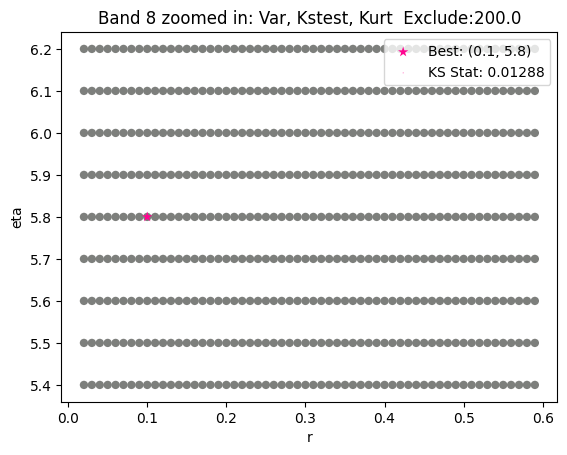

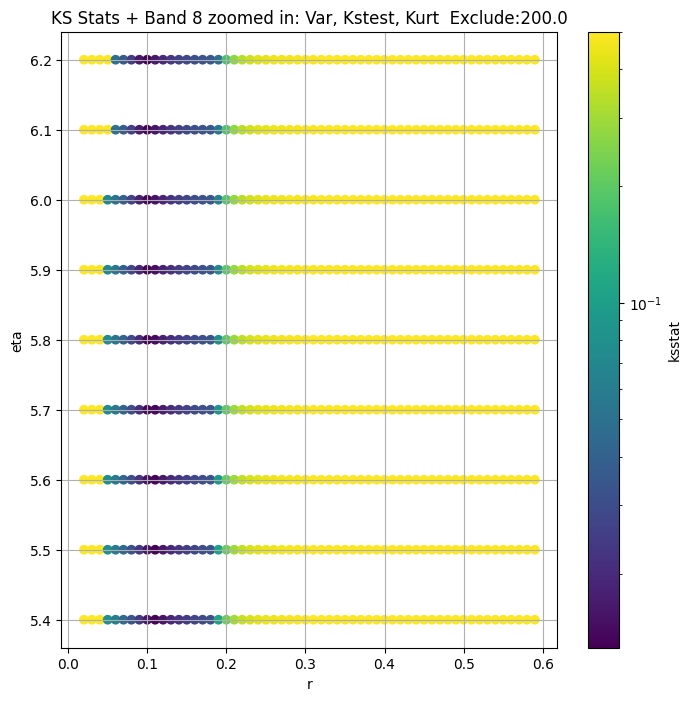

Band 11


  0%|          | 0/620 [00:00<?, ?it/s]

Finding Minimum after computing 620 CDFs
band 11, 75.0 + 100 = 175, ksstat: 0.006550607506561668, var: 8738170185420.784


  0%|          | 0/620 [00:00<?, ?it/s]

Finding Minimum after computing 620 CDFs
band 11, 75.0 + 75 = 150, ksstat: 0.005164671053162262, var: 8857155931129.205


  0%|          | 0/620 [00:00<?, ?it/s]

Finding Minimum after computing 620 CDFs
band 11, 75.0 + 50 = 125, ksstat: 0.0036038469613276503, var: 8993507423930.32


  0%|          | 0/620 [00:00<?, ?it/s]

Finding Minimum after computing 620 CDFs
band 11, 75.0 + 25 = 100, ksstat: 0.0024960013560198268, var: 9144432111146.162


  0%|          | 0/620 [00:00<?, ?it/s]

Finding Minimum after computing 620 CDFs
band 11, 75.0 + 0 = 75, ksstat: 0.002436352136907849, var: 9315511702771.133


  0%|          | 0/620 [00:00<?, ?it/s]

Finding Minimum after computing 620 CDFs
band 11, 75.0 + -25 = 50, ksstat: 0.003554518525949679, var: 9526371102407.336


  0%|          | 0/620 [00:00<?, ?it/s]

Finding Minimum after computing 620 CDFs
band 11, 75.0 + -50 = 25, ksstat: 0.004944364975149829, var: 9811016640565.043


  0%|          | 0/620 [00:00<?, ?it/s]

Finding Minimum after computing 620 CDFs
band 11, 75.0 + -75 = 0, ksstat: 0.0077804752318990575, var: 10462887871677.31
Number of samples: 63168, Without approximation : 31584.0


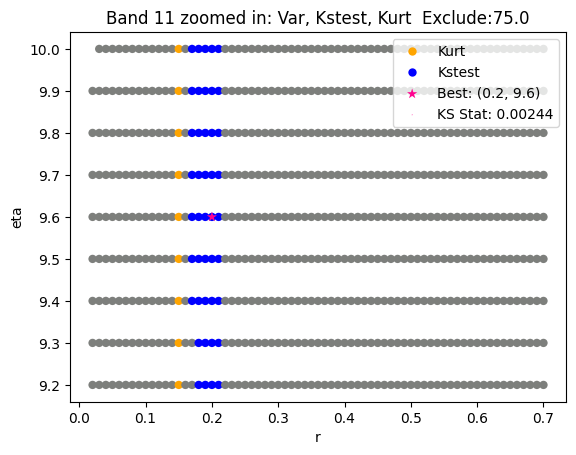

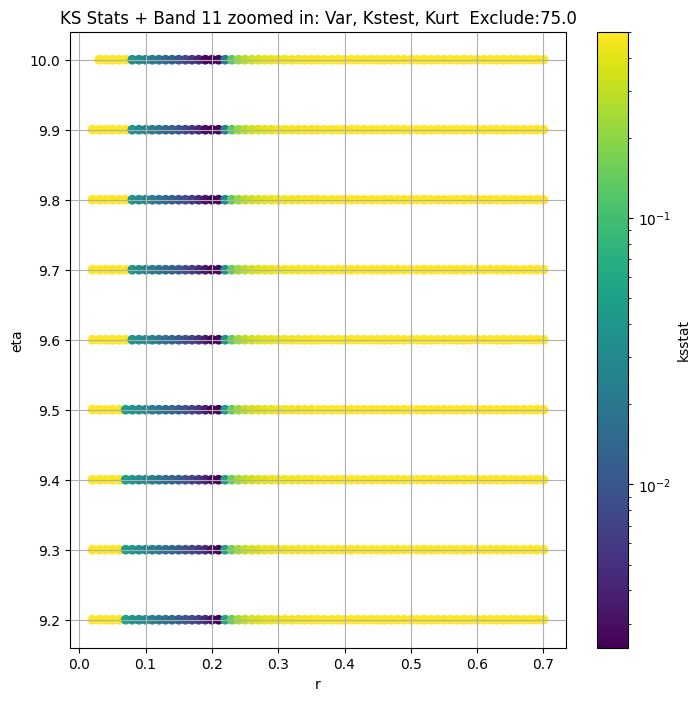

Band 14


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + 100 = 600, ksstat: 0.022949548190738467, var: 68801596432462.23


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + 75 = 575, ksstat: 0.024154195292228398, var: 70300683960809.85


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + 50 = 550, ksstat: 0.02549968710442152, var: 71857967292924.23


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + 25 = 525, ksstat: 0.02594797619589717, var: 73465920650667.83


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + 0 = 500, ksstat: 0.024944493016735625, var: 75133140574770.23


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + -25 = 475, ksstat: 0.023957416844676338, var: 76869459993135.31


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + -50 = 450, ksstat: 0.024711970579589737, var: 78687456143478.05


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + -75 = 425, ksstat: 0.024864259590498372, var: 80606283171898.72


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + -100 = 400, ksstat: 0.023804310504480064, var: 82621155445485.05
Number of samples: 100000, Without approximation : 87360.0


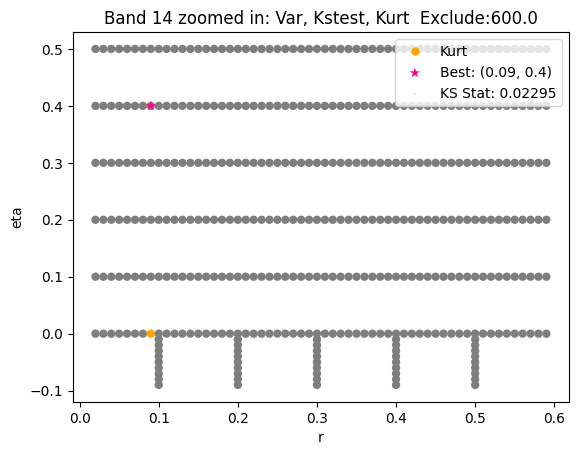

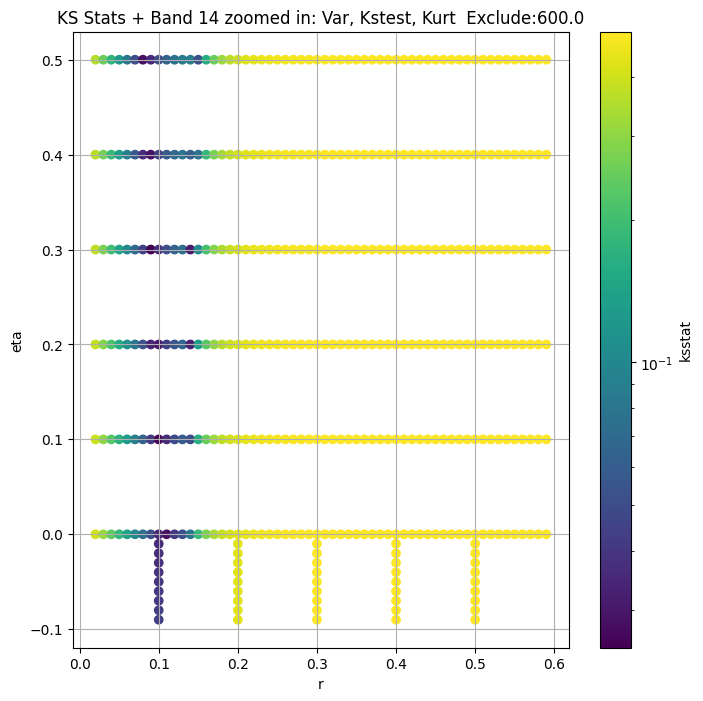

Band 17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.014406611442740691, var: 369911545957366.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.014035768455713568, var: 374707484377955.25


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.013605587961516674, var: 380256478520055.5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.01347162061910874, var: 387249126439068.7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.012848868407637437, var: 399044973851055.3
Number of samples: 100000, Without approximation : 100000.0


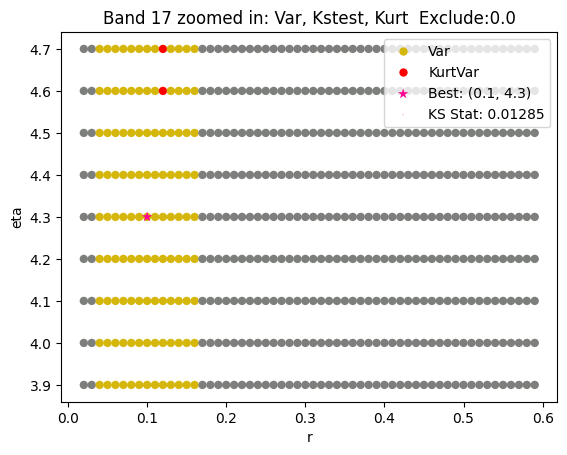

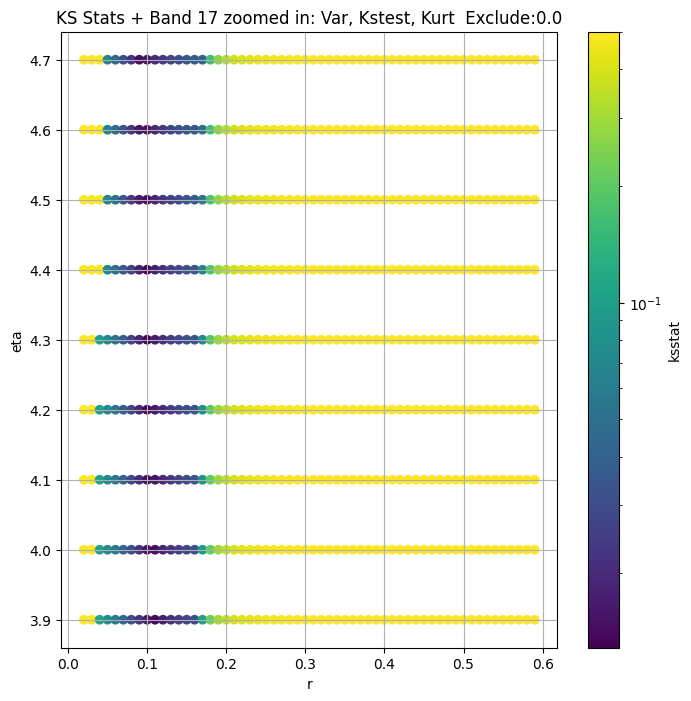

Band 20


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 100 = 125, ksstat: 0.0037398592755740236, var: 114006379840811.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 75 = 100, ksstat: 0.003274803771256673, var: 115563032815970.11


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 50 = 75, ksstat: 0.0027246575017436173, var: 117294652872119.48


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 25 = 50, ksstat: 0.002128622855293555, var: 119286139206284.39


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 0 = 25, ksstat: 0.0014715827146809524, var: 121789298558765.31


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + -25 = 0, ksstat: 0.0016187539264496675, var: 126281703477636.95
Number of samples: 100000, Without approximation : 100000.0


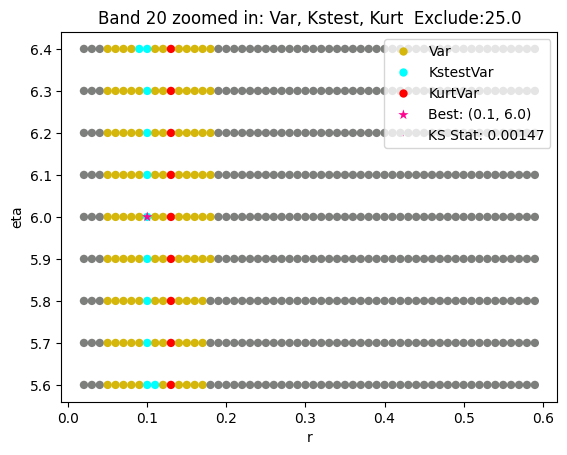

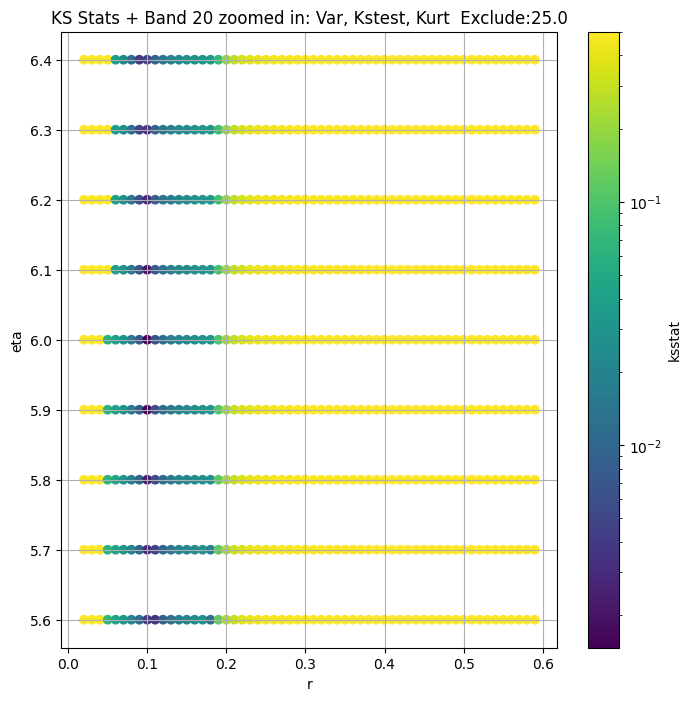

Band 23


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 100 = 125, ksstat: 0.0024091071424427422, var: 12838822449348.025


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 75 = 100, ksstat: 0.0018533211639795572, var: 12976329971718.78


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 50 = 75, ksstat: 0.0013914478538737032, var: 13130038978604.463


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 25 = 50, ksstat: 0.001621483134993551, var: 13308123493736.15


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 0 = 25, ksstat: 0.0008972847652777283, var: 13529662528674.15


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + -25 = 0, ksstat: 0.0027099958277784775, var: 13952162996874.242
Number of samples: 100000, Without approximation : 100000.0


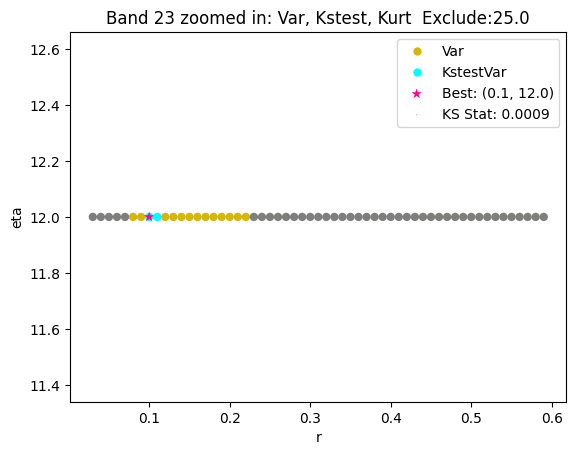

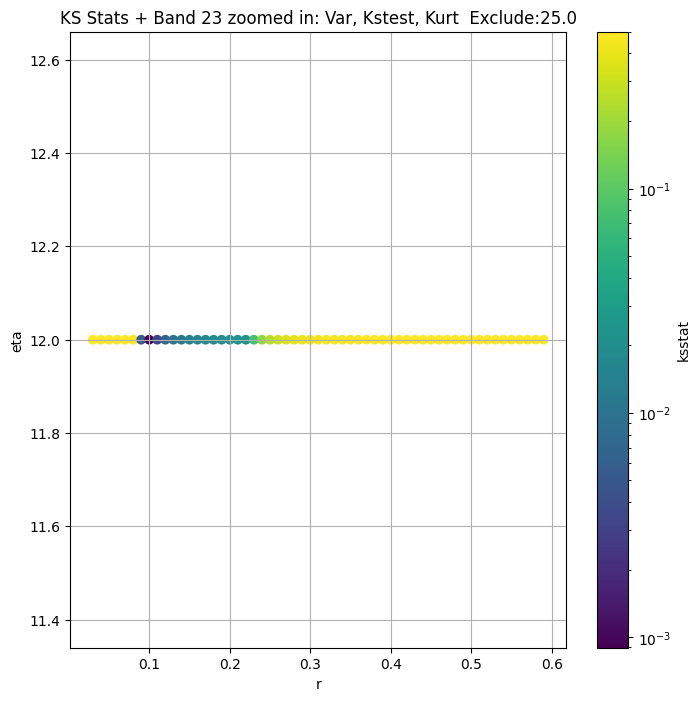

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 100 = 125, ksstat: 0.002877856311991618, var: 3187180048296.6367


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 75 = 100, ksstat: 0.0023763450192071274, var: 3228375255449.295


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 50 = 75, ksstat: 0.0019143405088774407, var: 3274187324883.244


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 25 = 50, ksstat: 0.0014673400424173866, var: 3326646762783.1313


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 0 = 25, ksstat: 0.00118892360734002, var: 3391247479364.459


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + -25 = 0, ksstat: 0.002224336036698471, var: 3501565299877.888
Number of samples: 100000, Without approximation : 100000.0


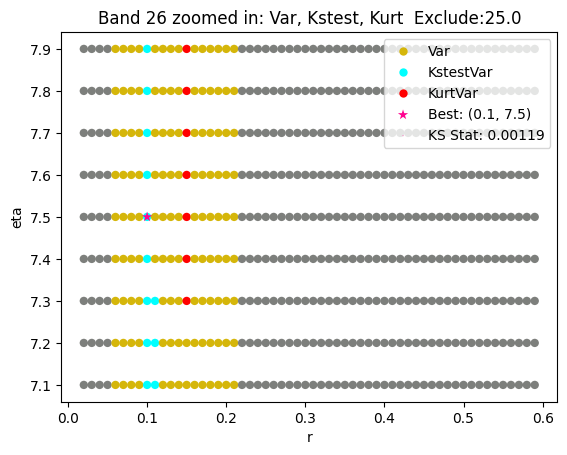

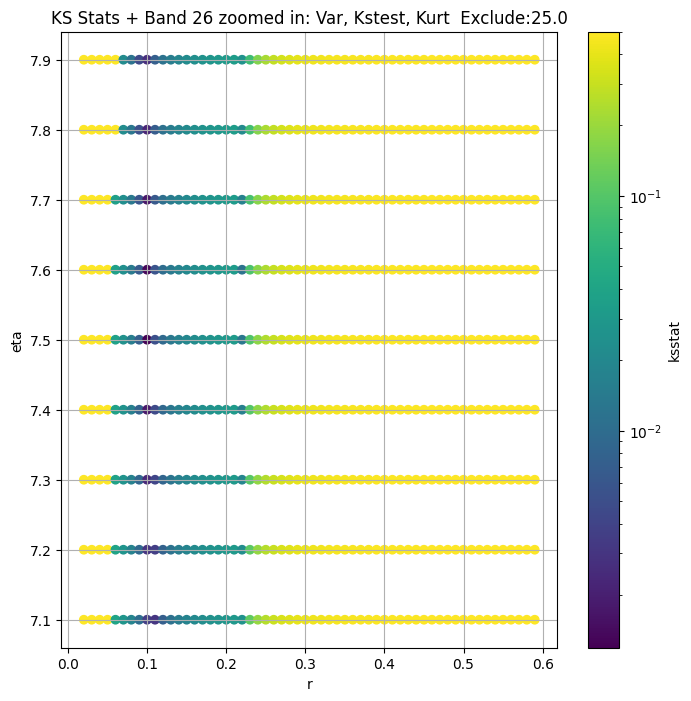

Band 30


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + 100 = 200, ksstat: 0.005552781829032679, var: 35621440958.11011


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + 75 = 175, ksstat: 0.005198619970973879, var: 36168336977.28993


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + 50 = 150, ksstat: 0.004735935417047539, var: 36756253399.22073


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + 25 = 125, ksstat: 0.00430431395477153, var: 37396898261.219055


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + 0 = 100, ksstat: 0.0038485589439426968, var: 38104555225.939255


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + -25 = 75, ksstat: 0.0038726298068779696, var: 38901397056.90847


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + -50 = 50, ksstat: 0.004070184016738365, var: 39834187217.398735


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + -75 = 25, ksstat: 0.004637149687859998, var: 41007723821.86944


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + -100 = 0, ksstat: 0.00527515130845857, var: 43207613574.09835
Number of samples: 100000, Without approximation : 100000.0


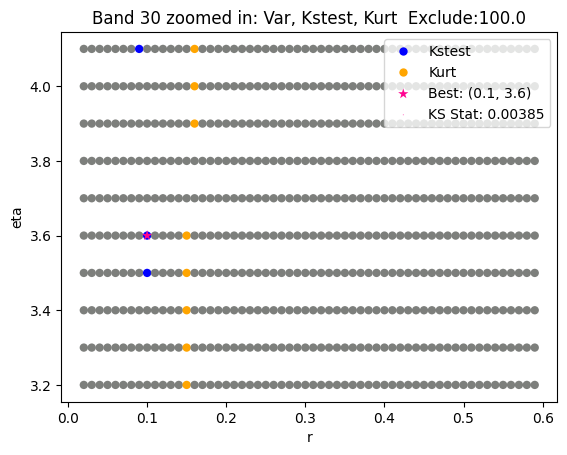

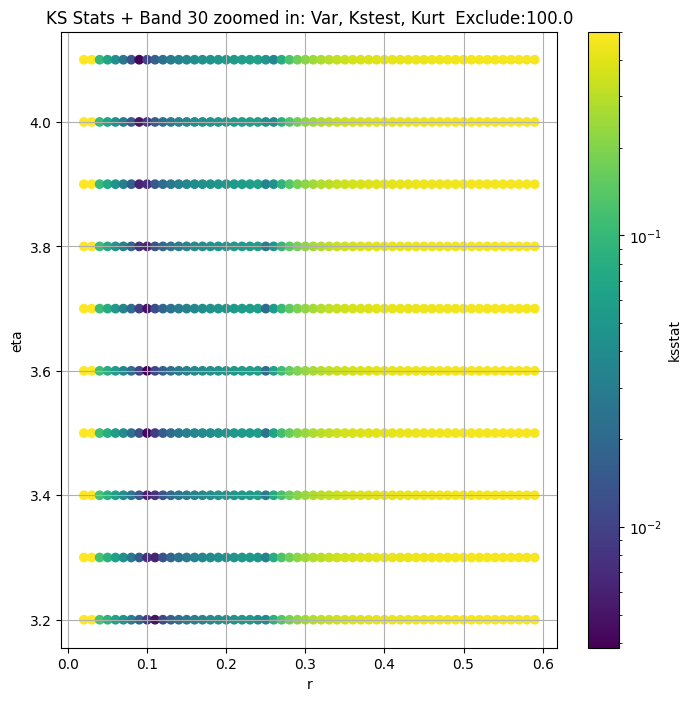

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     3.398420e+14  2.885051e+14  3.995387e+14   9.000777    4.606562   
5     7.662681e+14  6.650100e+14  8.746015e+14  20.540274   17.320919   
8     1.821735e+14  1.584012e+14  2.083324e+14  26.358736   19.246767   
11    1.046289e+13  9.638602e+12  1.150689e+13   9.936844    3.401560   
14    1.560234e+14  1.304501e+14  1.856061e+14  45.615188   30.371928   
17    3.990450e+14  3.719449e+14  4.288389e+14   5.597486    3.714605   
20    1.262817e+14  1.167970e+14  1.372043e+14   7.630152    4.533955   
23    1.395216e+13  1.305865e+13  1.496807e+13   4.887635    2.577196   
26    3.501565e+12  3.257119e+12  3.775443e+12   6.210594    3.889244   
30    4.320761e+10  3.905582e+10  4.823722e+10  14.671866    8.267646   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      13.104665         1344.0             0.013060        0.1          6.7   
5      23.905913         4032.0             0.015652        0.1          3.5   
8      34.415209        11424.0             0.012876        0.1          5.8   
11     23.645956        31584.0             0.002436        0.2          9.6   
14     68.155309        87360.0             0.025490        0.1          0.1   
17      9.365635       100000.0             0.012849        0.1          4.3   
20     17.732023       100000.0             0.001472        0.1          6.0   
23     12.244421       100000.0             0.000897        0.1         12.0   
26     12.906360       100000.0             0.001189        0.1          7.5   
30     37.024622       100000.0             0.003849        0.1          3.6   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.457178e-05                     0.0        3.398420e+14   
5      1.526846e-03                    75.0        3.481080e+14   
8      1.069913e-05                   200.0        8.305758e+13   
11     1.484310e+04                    75.0        9.315512e+12   
14     6.334108e+00                   500.0        6.880160e+13   
17     4.434212e-04                     0.0        3.990450e+14   
20     1.215558e-05                    25.0        1.217893e+14   
23     4.858093e-09                    25.0        1.352966e+13   
26     5.998589e-08                    25.0        3.391247e+12   
30     1.392762e-07                   100.0        3.810456e+10   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.036919          0.010044    0.18       7.0   
5                    0.021346          0.015652    0.10       3.5   
8                    0.012692          0.012876    0.10       5.8   
11                   0.007637          0.002436    0.20       9.6   
14                   0.004593          0.022950    0.09       0.4   
17                   0.004293          0.012849    0.10       4.3   
20                   0.004293          0.001472    0.10       6.0   
23                   0.004293          0.000897    0.10      12.0   
26                   0.004293          0.001189    0.10       7.5   
30                   0.004293          0.003849    0.10       3.6   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     1.000000e+05                  0.0      18387.0  
5     1.526846e-03                 75.0       7654.0  
8     1.069913e-05                200.0      11424.0  
11    1.484310e+04                 75.0     303547.0  
14    1.322165e-02                600.0       3453.0  
17    4.434212e-04                  0.0      11259.0  
20    1.215558e-05                 25.0     854296.0  
23    4.858093e-09                 25.0    2

In [18]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

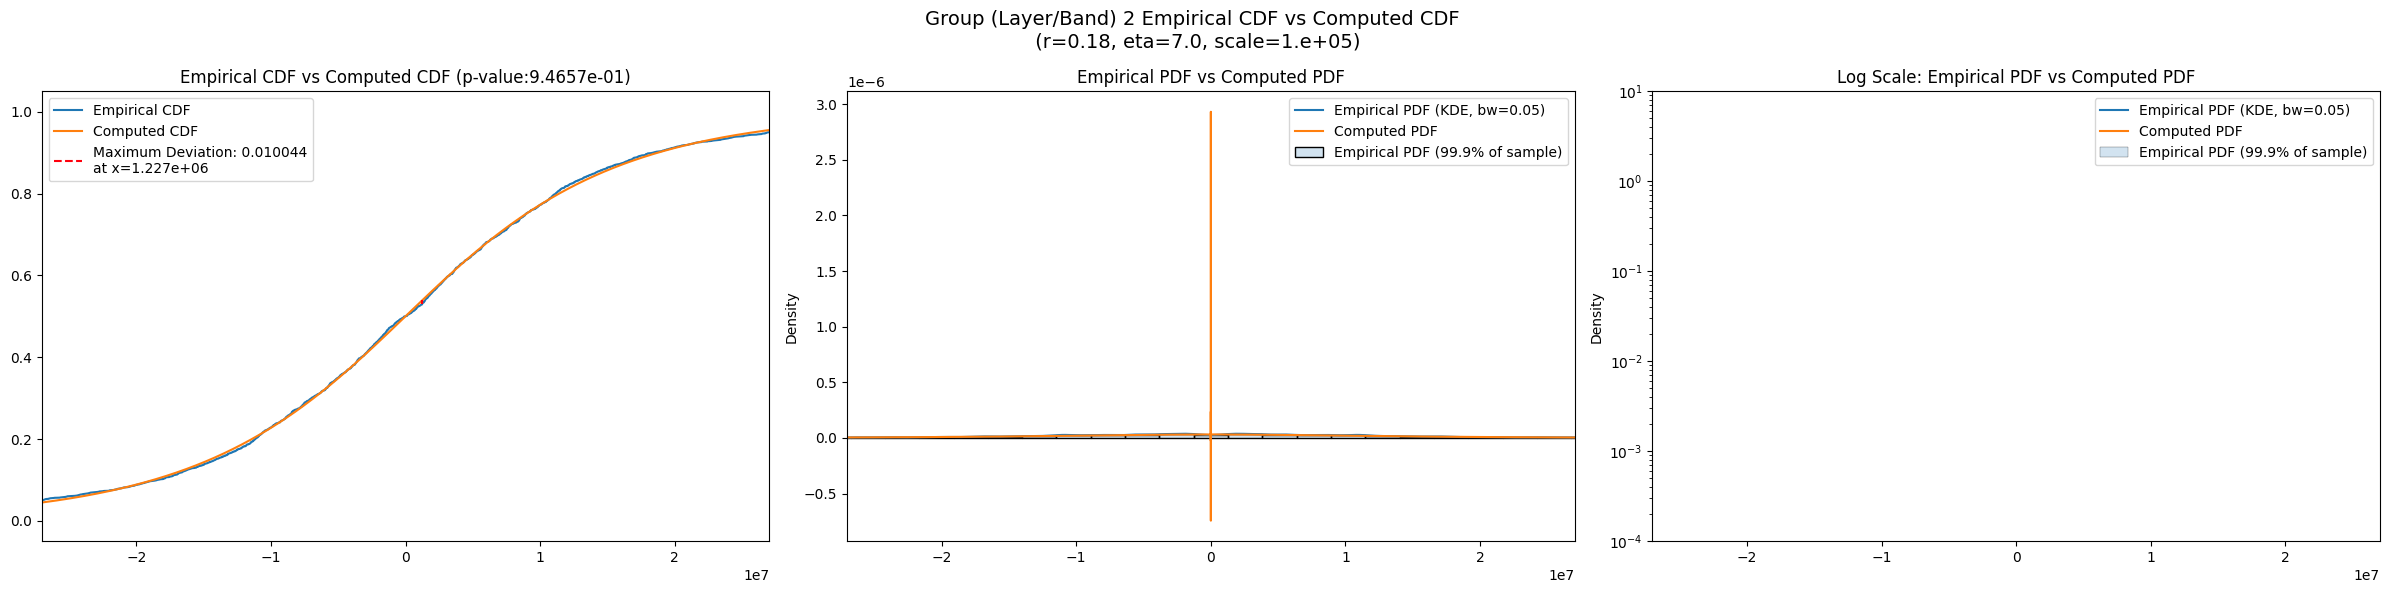

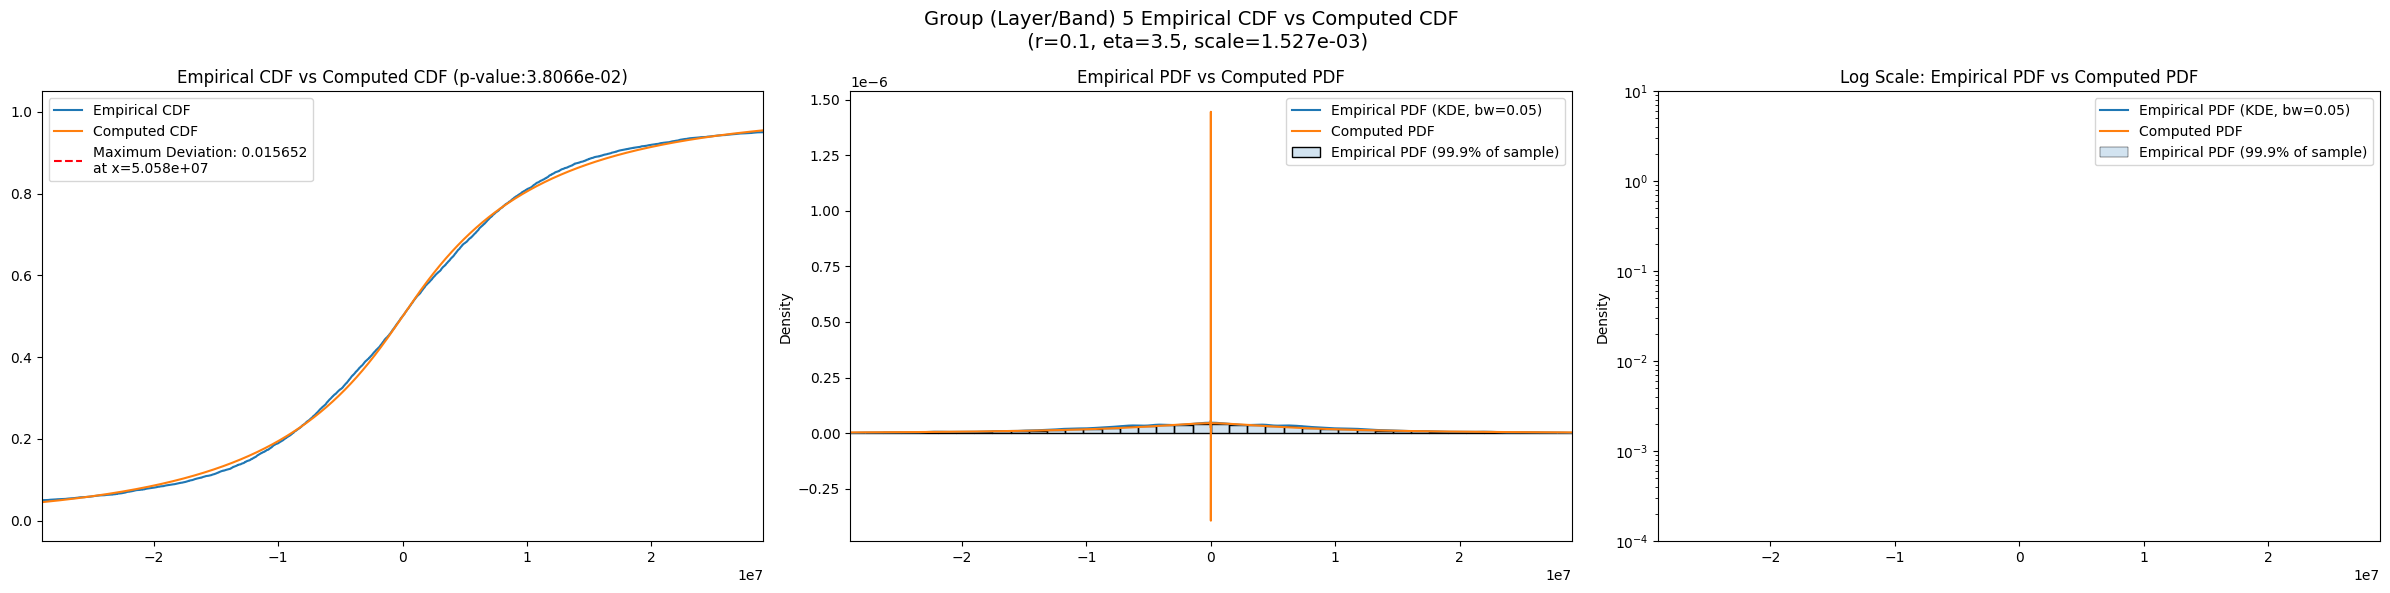

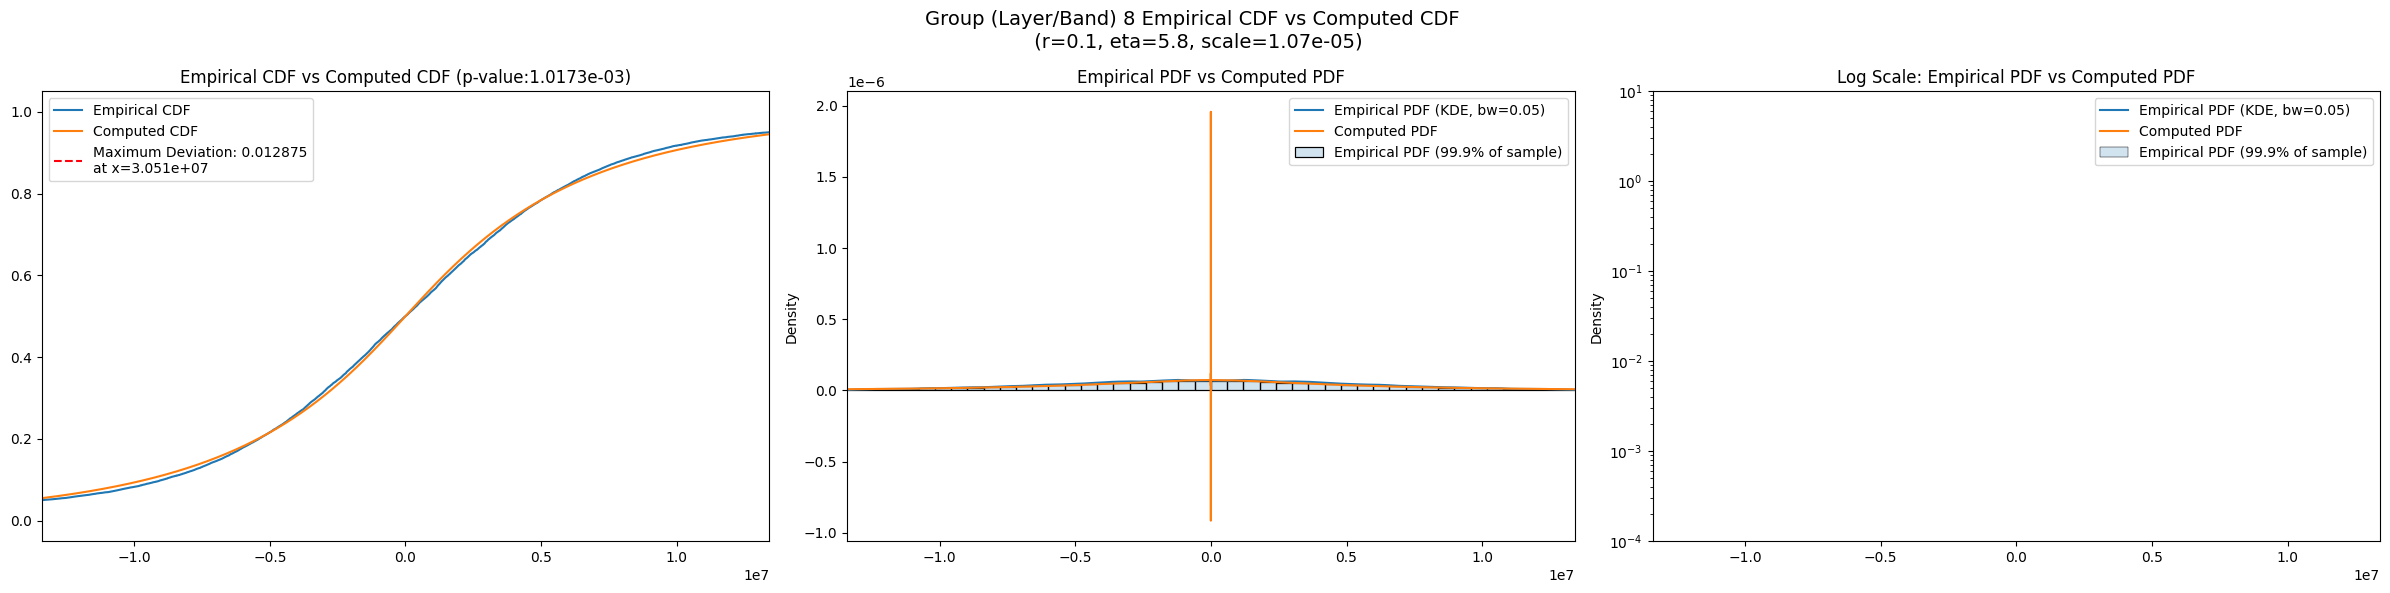

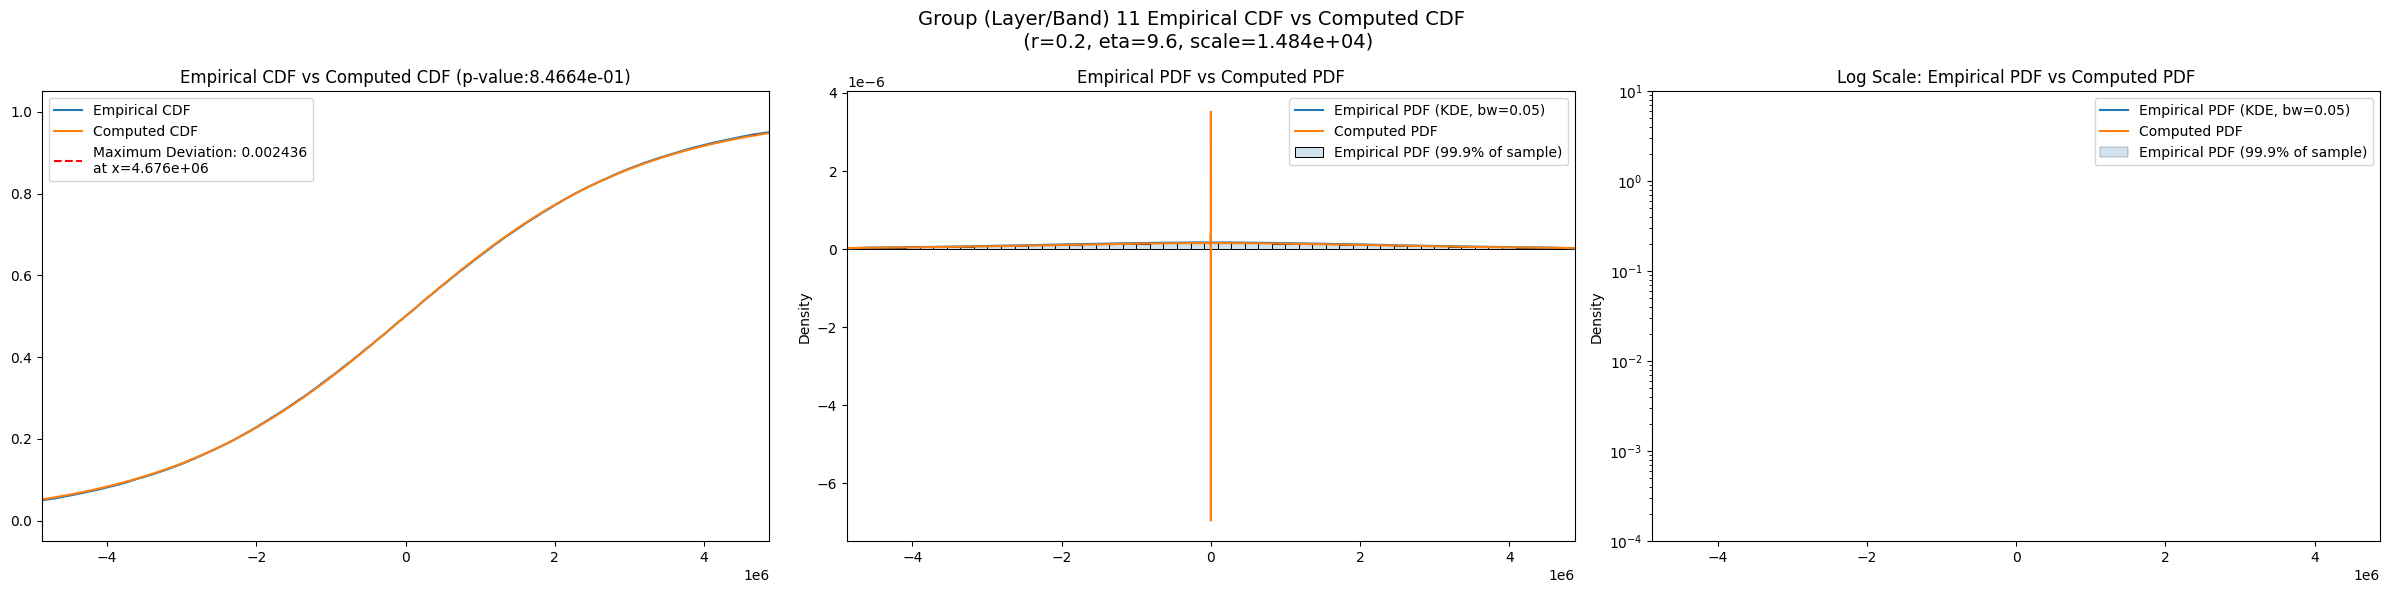

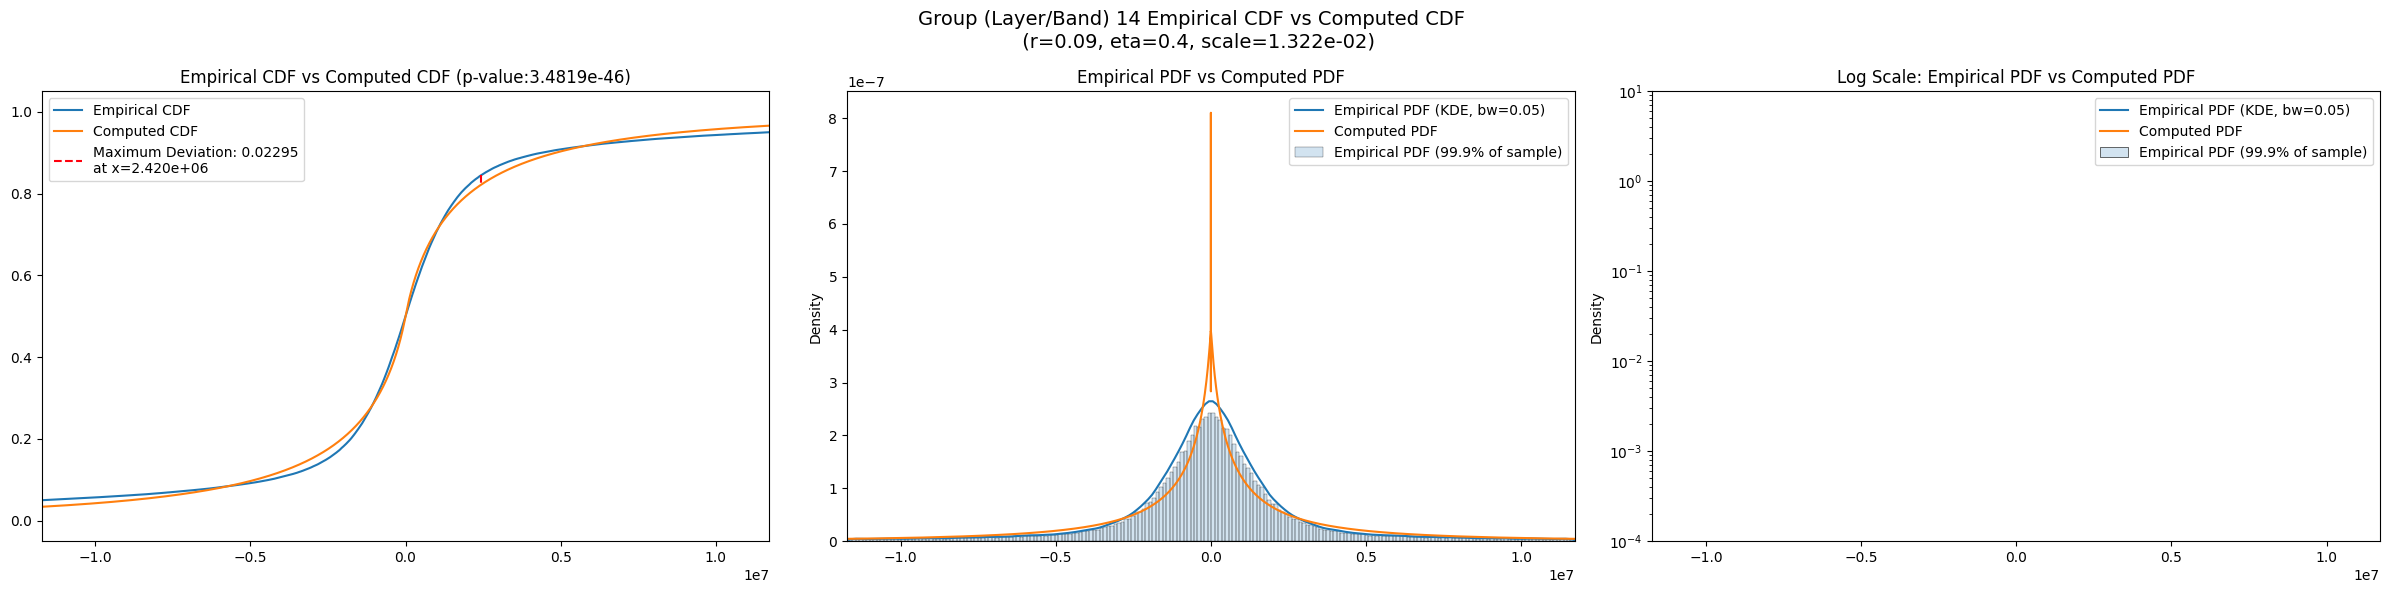

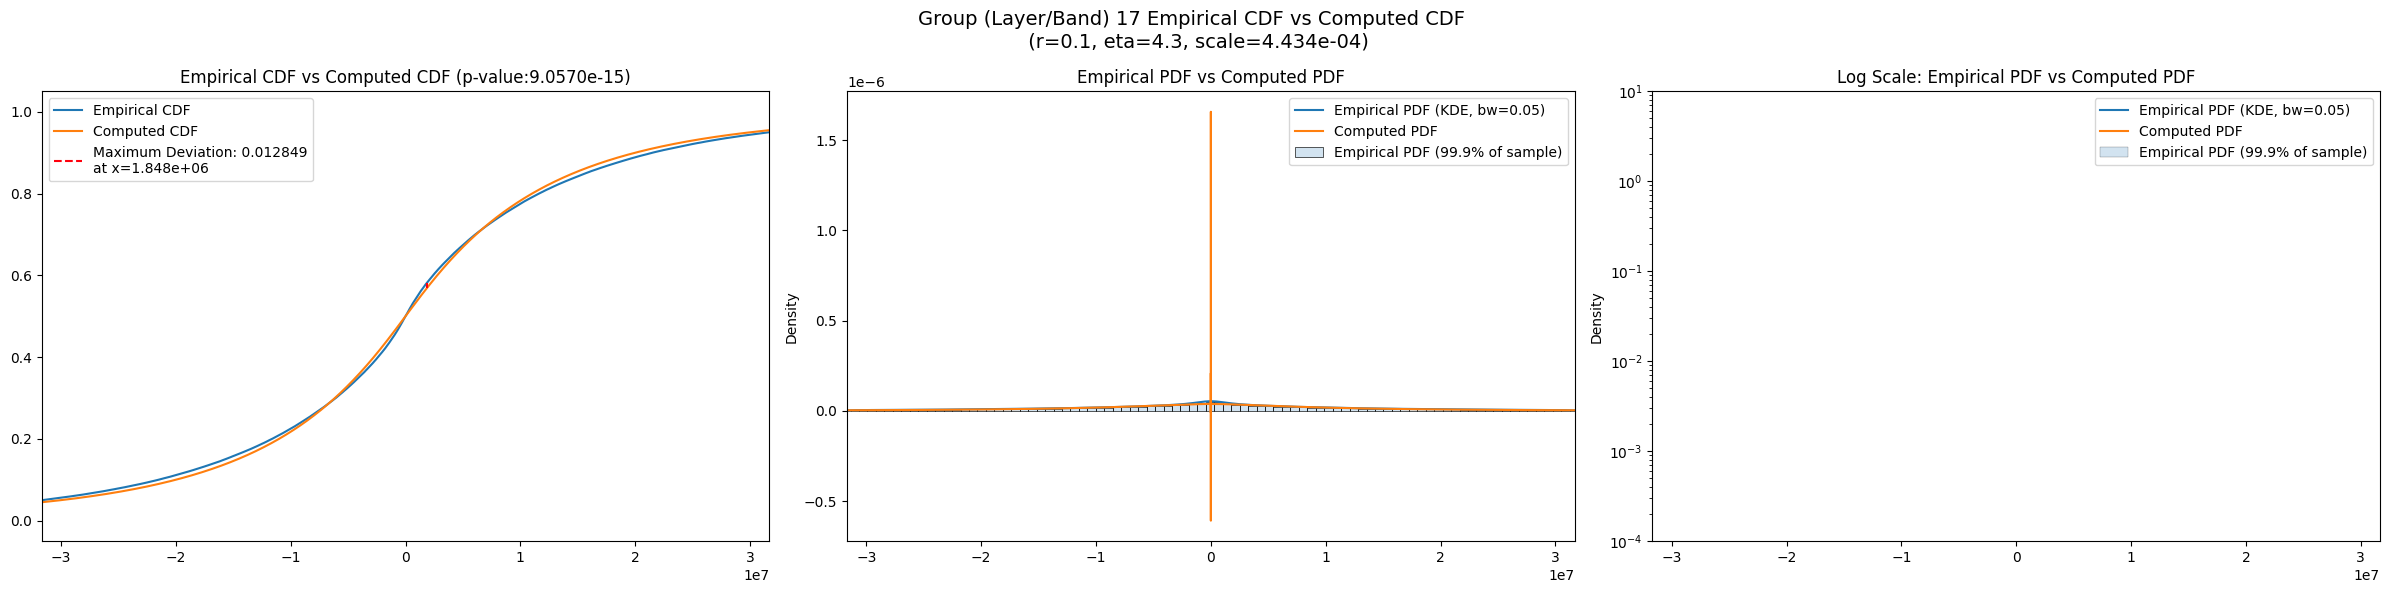

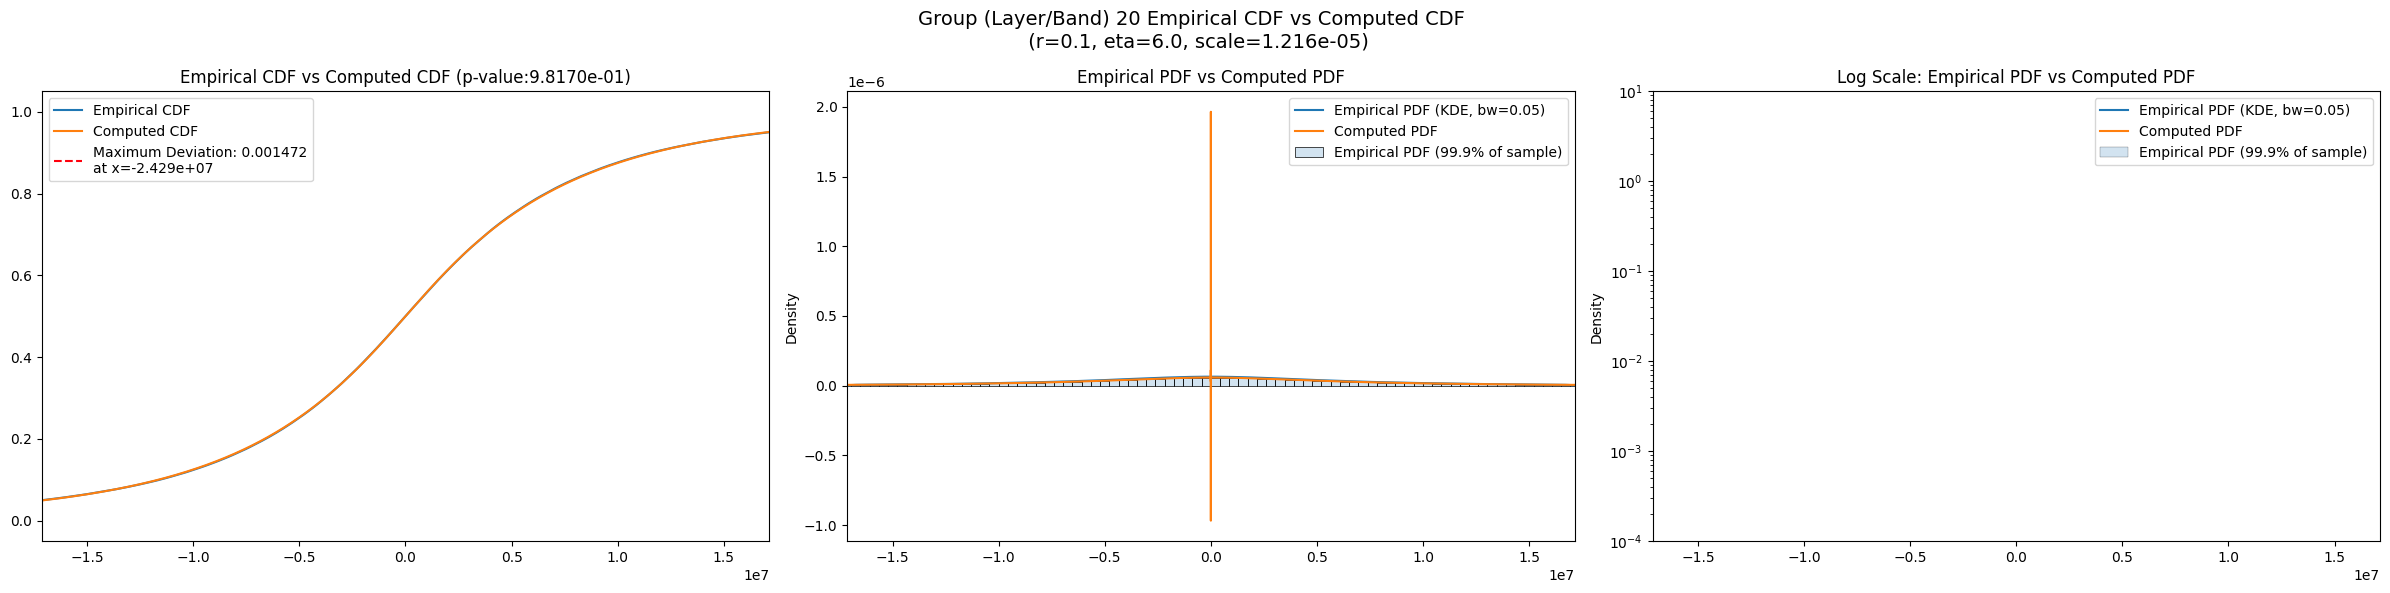

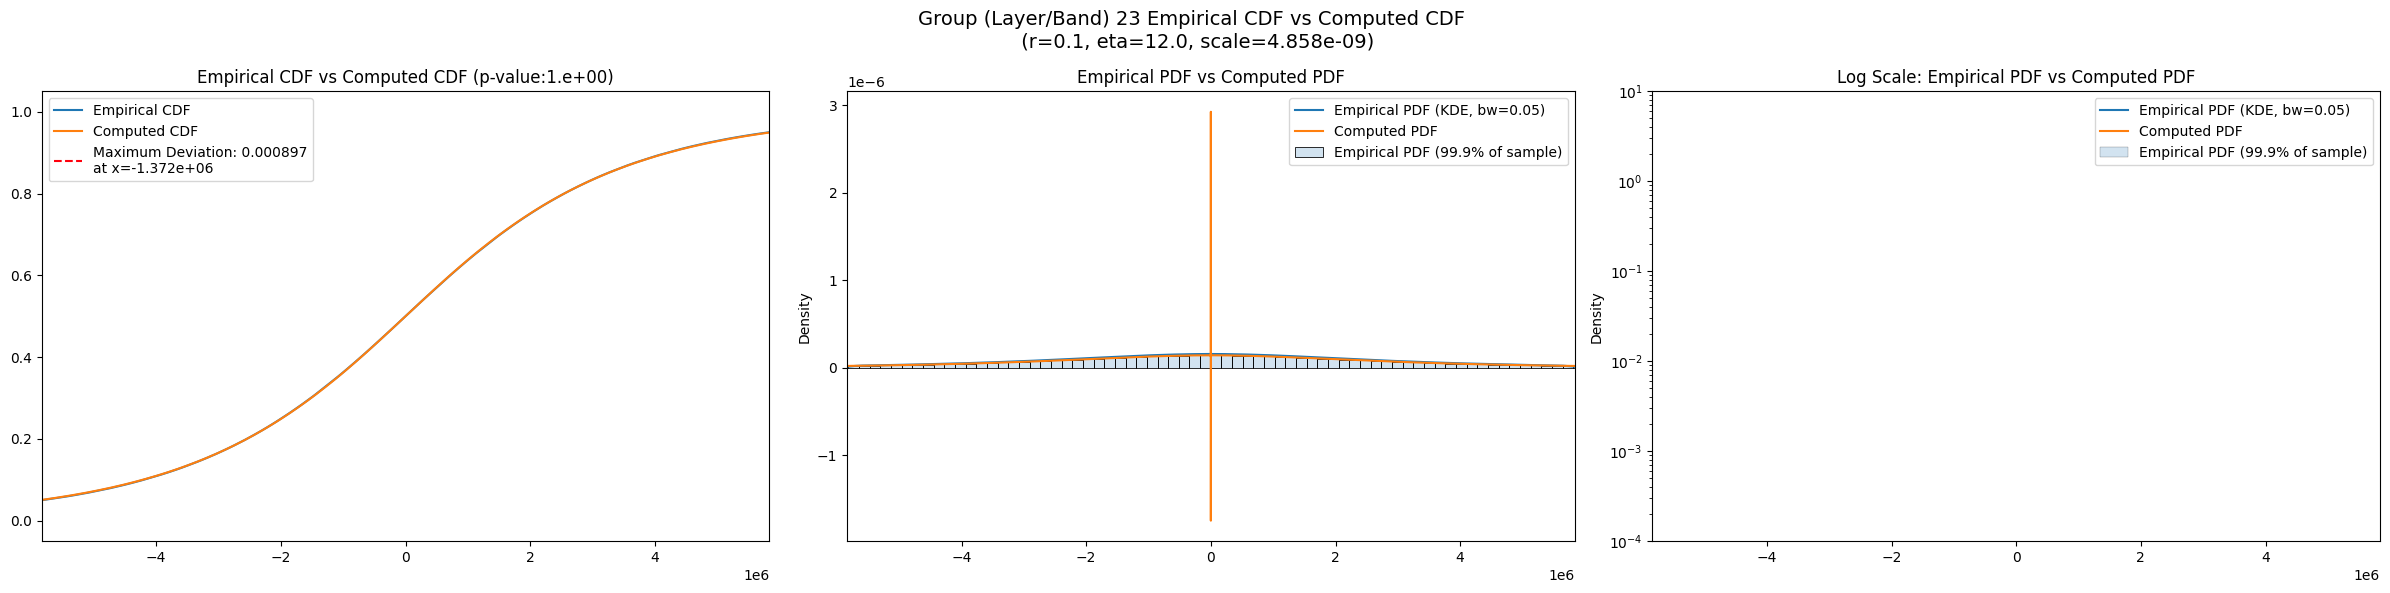

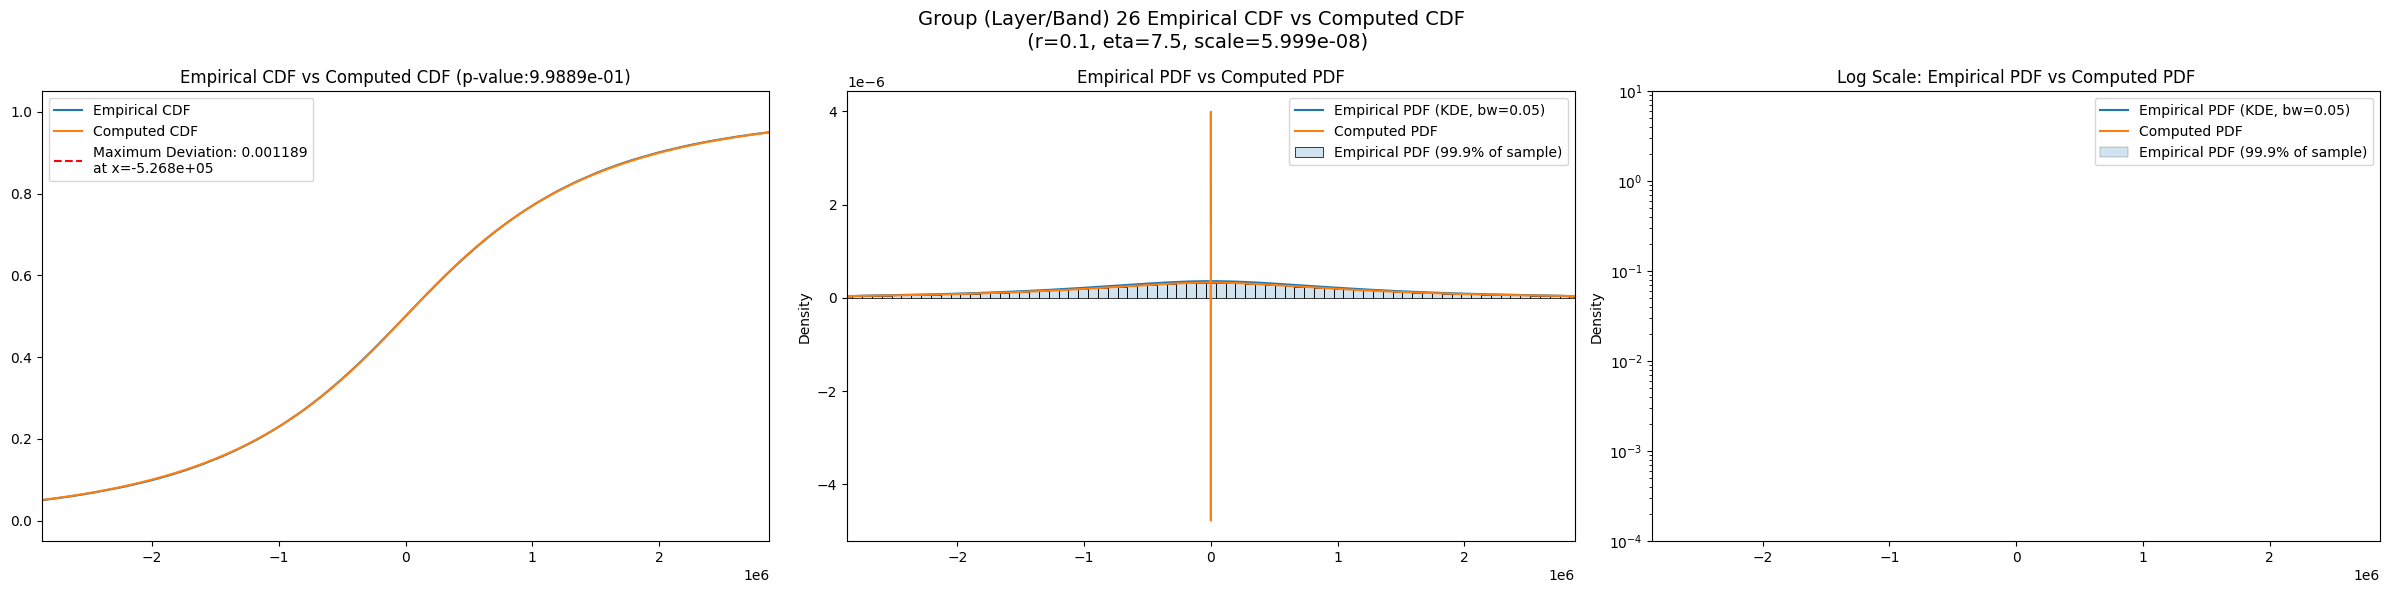

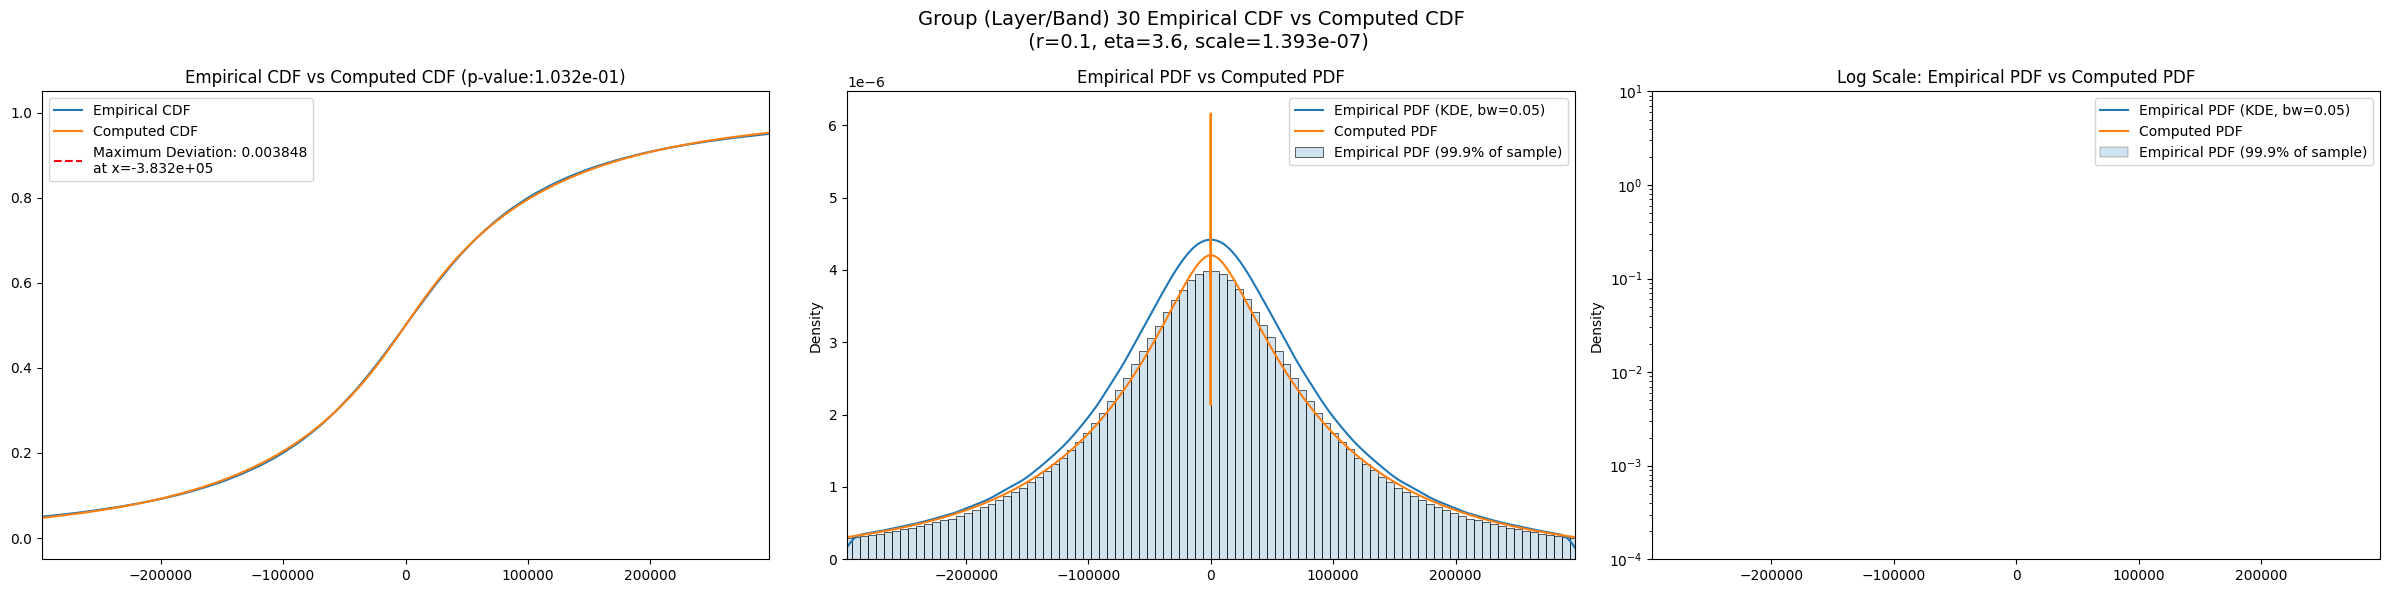

In [19]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [20]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [21]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     3.398420e+14  2.885051e+14  3.995387e+14   9.000777    4.606562   
5     7.662681e+14  6.650100e+14  8.746015e+14  20.540274   17.320919   
8     1.821735e+14  1.584012e+14  2.083324e+14  26.358736   19.246767   
11    1.046289e+13  9.638602e+12  1.150689e+13   9.936844    3.401560   
14    1.560234e+14  1.304501e+14  1.856061e+14  45.615188   30.371928   
17    3.990450e+14  3.719449e+14  4.288389e+14   5.597486    3.714605   
20    1.262817e+14  1.167970e+14  1.372043e+14   7.630152    4.533955   
23    1.395216e+13  1.305865e+13  1.496807e+13   4.887635    2.577196   
26    3.501565e+12  3.257119e+12  3.775443e+12   6.210594    3.889244   
30    4.320761e+10  3.905582e+10  4.823722e+10  14.671866    8.267646   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      13.104665         1344.0             0.013060        0.1          6.7   
5      23.905913         4032.0             0.015652        0.1          3.5   
8      34.415209        11424.0             0.012876        0.1          5.8   
11     23.645956        31584.0             0.002436        0.2          9.6   
14     68.155309        87360.0             0.025490        0.1          0.1   
17      9.365635       100000.0             0.012849        0.1          4.3   
20     17.732023       100000.0             0.001472        0.1          6.0   
23     12.244421       100000.0             0.000897        0.1         12.0   
26     12.906360       100000.0             0.001189        0.1          7.5   
30     37.024622       100000.0             0.003849        0.1          3.6   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       1000000.0              0.421958         1.739630e-217   
5     ...       1000000.0              0.401108          0.000000e+00   
8     ...       1000000.0              0.351109          0.000000e+00   
11    ...       1000000.0              0.220091          0.000000e+00   
14    ...       1000000.0              0.161955          0.000000e+00   
17    ...       1000000.0              0.393064          0.000000e+00   
20    ...       1000000.0              0.364224          0.000000e+00   
23    ...       1000000.0              0.236471          0.000000e+00   
26    ...       1000000.0              0.083940          0.000000e+00   
30    ...        134048.0              0.037437         3.285520e-122   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         1000000.0             0.385427        3.663250e-180  1000000.0   
5         1000000.0             0.364740         0.000000e+00  1000000.0   
8         1000000.0             0.306940         0.000000e+00  1000000.0   
11        1000000.0             0.175887         0.000000e+00  1000000.0   
14        1000000.0             0.115633         0.000000e+00  1000000.0   
17        1000000.0             0.356718         0.000000e+00  1000000.0   
20        1000000.0             0.321045         0.000000e+00  1000000.0   
23        1000000.0             0.190938         0.000000e+00  1000000.0   
26        1000000.0             0.047269        1.317810e-194  1000000.0   
30         117252.0             0.012676         2.186050e-14    95210.4   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.361886  3.507820e-158          9.990685e-01  
5          0.341901   0.000000e+00          2.737908e-01  
8          0.282913   0.000000e+00          4.489597e-02  
11         0.151027   0.000000e+00          9.917575e-01  
14         0.091195   0.00000

## Results

In [22]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [23]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.013060                 0.036919          0.010044   
5                0.015652                 0.021346          0.015652   
8                0.012876                 0.012692          0.012876   
11               0.002436                 0.007637          0.002436   
14               0.025490                 0.004593          0.022950   
17               0.012849                 0.004293          0.012849   
20               0.001472                 0.004293          0.001472   
23               0.000897                 0.004293          0.000897   
26               0.001189                 0.004293          0.001189   
30               0.003849                 0.004293          0.003849   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.421958             0.385427       0.361886  
5                 0.401108             0.364740       0.341901  
8                 0.351109             0.306940       0.282913  
11                0.220091             0.175887       0.151027  
14                0.161955             0.115633       0.091195  
17                0.393064             0.356718       0.333383  
20                0.364224             0.321045       0.297084  
23                0.236471             0.190938       0.166229  
26                0.083940             0.047269       0.018634  
30                0.037437             0.012676       0.007318

In [24]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2           3.398420e+14          0.010044    0.18       7.0  1.000000e+05   
5           3.481080e+14          0.015652    0.10       3.5  1.526846e-03   
8           8.305758e+13          0.012876    0.10       5.8  1.069913e-05   
11          9.315512e+12          0.002436    0.20       9.6  1.484310e+04   
14          6.880160e+13          0.022950    0.09       0.4  1.322165e-02   
17          3.990450e+14          0.012849    0.10       4.3  4.434212e-04   
20          1.217893e+14          0.001472    0.10       6.0  1.215558e-05   
23          1.352966e+13          0.000897    0.10      12.0  4.858093e-09   
26          3.391247e+12          0.001189    0.10       7.5  5.998589e-08   
30          3.810456e+10          0.003849    0.10       3.6  1.392762e-07   

      best_exclude_cutoff  
band                       
2                     0.0  
5                    75.0  
8                   200.0  
11                   75.0  
14                  600.0  
17                    0.0  
20                   25.0  
23                   25.0  
26                   25.0  
30                  100.0